# Gift Shop Customer Behavior Analysis Using CatBoost and Product Networks

**The goal** of this study is to analyze customer purchasing behavior in a gift shop **identifying product co-purchases** and **predicting repeat purchases**. 
  
Insights from product networks and machine learning are used to guide merchandising and marketing strategies.

## 1. Data Overview

### 1.1 Dataset Description

The dataset used in this study is the Online Retail dataset from the UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/352/online+retail) , which contains transactional records from a UK-based non-store online retail business that primarily sells unique all‑occasion gifts. The transactions span from December 1, 2010 to December 9, 2011, capturing nearly a full year of customer purchases and returns for a wide variety of gift products. 

Each row in the dataset represents one item on an invoice, making it suitable for market basket and customer behavior analysis such as frequent itemset mining, product network construction, and retention modeling. The key attributes include:

- InvoiceNo – a unique transaction identifier; codes beginning with “C” indicate cancellations/returns.
- StockCode – a unique product identifier.
- Description – product name or description.
- Quantity – number of units purchased in the transaction.
- InvoiceDate – date and time of the transaction.
- UnitPrice – price per unit in GBP sterling.
- CustomerID – unique identifier for the customer.
- Country – country of the customer. 


This transactional dataset enables reconstruction of baskets (items purchased per transaction), customer histories (purchase sequences over time), and product co‑purchase networks, making it ideal for both descriptive analytics and predictive modeling in e‑commerce.

In [2]:
# Import libriries
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read in the xlsx file as a pandas dataframe
gift_df = pd.read_excel('Online_Retail.xlsx')
gift_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [4]:
# Explore the data
gift_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


The data types of several variables need to be changed: 'CustomerID', 'StockCode', 'InvoiceNo', 'Country'.

Before converting to strings, we will check whether object columns already contain only string values  
or if there are mixed types (e.g., integers or floats).

In [5]:
# Check the actual data types stored inside object columns

print("StockCode types:\n", gift_df['StockCode'].apply(type).value_counts(), "\n")
print("InvoiceNo types:\n", gift_df['InvoiceNo'].apply(type).value_counts(), "\n")
print("CustomerID types:\n", gift_df['CustomerID'].apply(type).value_counts(), "\n")
print("Description types:\n", gift_df['Description'].apply(type).value_counts(), "\n")

StockCode types:
 StockCode
<class 'int'>    487036
<class 'str'>     54873
Name: count, dtype: int64 

InvoiceNo types:
 InvoiceNo
<class 'int'>    532618
<class 'str'>      9291
Name: count, dtype: int64 

CustomerID types:
 CustomerID
<class 'float'>    541909
Name: count, dtype: int64 

Description types:
 Description
<class 'str'>      540454
<class 'float'>      1454
<class 'int'>           1
Name: count, dtype: int64 



Several columns contain mixed value types, so variables need to be converted to consistent types before analysis.

In [6]:
# Check for null values
gift_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Null values are mostly in the 'CustomerID' column. The reason might be that some orders were placed by guest users who did not create an account, or there were incomplete records where the customer information was not captured.

In [7]:
# Explore null values by countries
gift_df[gift_df['CustomerID'].isna()]['Country'].value_counts().head()

Country
United Kingdom    133600
EIRE                 711
Hong Kong            288
Unspecified          202
Switzerland          125
Name: count, dtype: int64

In [8]:
# Orders with null values VS Total amount of orders
print("Orders with null values: "+ str(gift_df[gift_df['CustomerID'].isna()]['InvoiceNo'].nunique()))
print("Total amount of orders: " + str(gift_df['InvoiceNo'].nunique()))

Orders with null values: 3710
Total amount of orders: 25900


This means that around 14% of orders have null values in 'CustomerID'.

## 2. Exploratory Data Analysis (EDA)

In [9]:
# Generate descriptive statistics
gift_df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,541909.0,9.55225,-80995.0,1.0,3.0,10.0,80995.0,218.081158
InvoiceDate,541909,2011-07-04 13:34:57.156386048,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN
UnitPrice,541909.0,4.611114,-11062.06,1.25,2.08,4.13,38970.0,96.759853
CustomerID,406829.0,15287.69057,12346.0,13953.0,15152.0,16791.0,18287.0,1713.600303


The 'UnitPrice' and 'Quantity' have negative values, the reasons might be in the 'Description' column.

The large difference between the maximum and the mean value of 'Quantity' likely reflects the presence of two different customer groups: wholesalers and regular customers.

In [10]:
# Check the negative 'UnitPrice'
gift_df[gift_df['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [11]:
# View the amount of transactions by country
gift_df['Country'].value_counts()

Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


91% of all transactions come from United Kingdom

In [12]:
# Check for the duplicates
gift_df.duplicated().sum()

np.int64(5268)

In [12]:
# Data preparation: fill null values, delete 0 or negative prices, convert data types

# Delete rows with UnitPrice <= 0
gift_df = gift_df[gift_df['UnitPrice'] > 0].copy()

# Remove missing customers
gift_df = gift_df[gift_df['CustomerID'].notnull()]

# Standardize descriptions and fill missing descriptions with 'Unknown'
gift_df['Description'] = gift_df['Description'].fillna('Unknown')

# Remove duplicates
gift_df = gift_df.drop_duplicates()

# Fix data types
gift_df['InvoiceNo'] = gift_df['InvoiceNo'].astype(str)
gift_df['StockCode'] = gift_df['StockCode'].astype(str)
gift_df['CustomerID'] = gift_df['CustomerID'].astype(str)
gift_df['Country'] = gift_df['Country'].astype('category')

# Remove .0 from 'CustomerID'
gift_df['CustomerID'] = gift_df['CustomerID'].str.replace('\.0', '', regex=True)

gift_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401564 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401564 non-null  object        
 1   StockCode    401564 non-null  object        
 2   Description  401564 non-null  object        
 3   Quantity     401564 non-null  int64         
 4   InvoiceDate  401564 non-null  datetime64[ns]
 5   UnitPrice    401564 non-null  float64       
 6   CustomerID   401564 non-null  object        
 7   Country      401564 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 24.9+ MB


Next, two dataframes will be created for different purposes: 
 - 'gift_tr' with all transactions, including returns (negative quantities), but removing rows with zero or negative prices. This dataframe will be used to build the transaction funnel.
 - 'gift_cl' will be a cleaned version where we remove transactions with missing customer IDs, zero or negative prices, and negative quantities. This dataset will be used for cohort analysis, RFM analysis, and machine learning models.

In [13]:
# Create dataframe for the transaction funnel
# Copy the original dataframe
gift_tr = gift_df.copy()

# Check min UnitPrice after cleaning
print(gift_tr['UnitPrice'].min())

# Check the shape of dataframe
print(gift_tr.shape)
gift_tr.describe().T

0.001
(401564, 8)


,count,mean,min,25%,50%,75%,max,std
Quantity,401564.0,12.149911,-80995.0,2.0,5.0,12.0,80995.0,249.512649
InvoiceDate,401564,2011-07-10 12:06:07.514567936,2010-12-01 08:26:00,2011-04-06 15:02:00,2011-07-29 15:32:30,2011-10-20 11:58:00,2011-12-09 12:50:00,NaN
UnitPrice,401564.0,3.47441,0.001,1.25,1.95,3.75,38970.0,69.767501


In [14]:
# Create a clean dataframe for general analysis
# Make a copy of the original dataframe
gift_cl = gift_df.copy()

# Remove cancelled invoices
gift_df = gift_df[~gift_df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove rows with negative Quantity (may indicate returns, which we exclude for general analysis)
gift_cl = gift_cl[gift_cl['Quantity'] > 0]

# Reset the index
gift_cl.reset_index(drop=True, inplace=True)

# Add total price column
gift_cl['TotalPrice'] = gift_cl['Quantity'] * gift_cl['UnitPrice']

# Check shape of the cleaned dataframe
print("Shape of df_clean:", gift_cl.shape)

# Check min and max UnitPrice and Quantity
print("UnitPrice min/max:", gift_cl['UnitPrice'].min(), "/", gift_cl['UnitPrice'].max())
print("Quantity min/max:", gift_cl['Quantity'].min(), "/", gift_cl['Quantity'].max())

Shape of df_clean: (392692, 9)
UnitPrice min/max: 0.001 / 8142.75
Quantity min/max: 1 / 80995


Number of rows = 392692.    
This means the rows, that contained:
- missing CustomerID
- negative Quantity (returns)
- negative or zero UnitPrice  
 
 were removed.    

Missing CustomerID = 0 - each row is linked to a specific customer.    
UnitPrice range: 0.001 - 8142.75 - minimum price is positive, maximum is high.    
Quantity range: 1 - 80995 - minimum unit is 1, but maximum is very high – will be checked later to see if this is an outlier (or a bulk order).

### 2.1 Price and Quantity Distributions

At first we will look at the:
- Total number of purchases (positive quantity) and returns (negative quantity).
- The number of unique customers who made purchases and returns.

In [15]:
# Count transactions
transactions_count = gift_tr['Quantity'].apply(lambda x: 'Purchase' if x > 0 else 'Return').value_counts()
print("Transaction count:\n ", transactions_count, "\n")

# Count unique customers by type
customers_count = gift_tr.groupby(gift_tr['Quantity'].apply(lambda x: 'Purchase' if x > 0 else 'Return'))['CustomerID'].nunique()
print("Customers count:\n ", customers_count, "\n")

Transaction count:
  Quantity
Purchase    392692
Return        8872
Name: count, dtype: int64 

Customers count:
  Quantity
Purchase    4338
Return      1589
Name: CustomerID, dtype: int64 



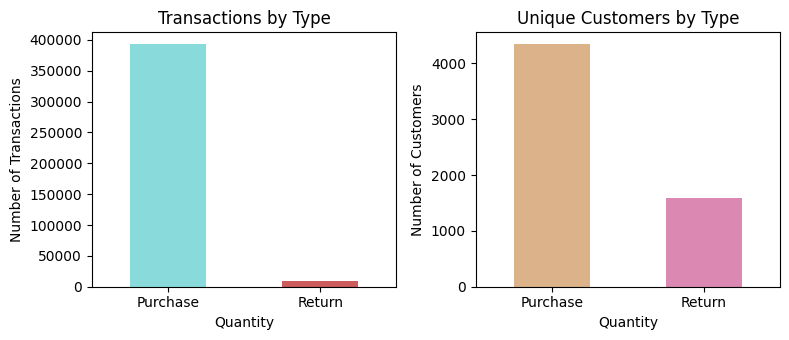

In [16]:
# Plot charts with total number of purchases and returns and total number of customers that made a return (negative quantity)
plt.figure(figsize = (8, 3.5))

# Bar chart for transactions
plt.subplot(1, 2, 1)
transactions_count.plot(kind='bar', color=['#89dbdb', 'indianred'])
plt.title('Transactions by Type')
plt.ylabel('Number of Transactions')
plt.xticks(rotation='horizontal') 

# Bar chart for unique customers
plt.subplot(1, 2, 2)
customers_count.plot(kind='bar', color=['#DBB289', '#DB89B2'])
plt.title('Unique Customers by Type')
plt.ylabel('Number of Customers')
plt.xticks(rotation='horizontal') 

plt.tight_layout()
plt.show()

1. **Transactions**: Only a very small fraction of all transactions are returns (only 2% of returns), indicating that most purchases are not refunded. 

2. **Customers**: A larger proportion of customers (37%) have made at least one return, even though the overall number of return transactions is small. This shows that while returns are rare at the transaction level, they are more common across individual customers.

In [17]:
# Display the total amount of customers who bought more than 100 units vs less
wholesale_customers = gift_tr[gift_tr['Quantity'] >= 100]['CustomerID'].unique() 
regular_customers = gift_tr[gift_tr['Quantity'] < 100]['CustomerID'].unique() 

print(len(wholesale_customers))
print(len(regular_customers))

739
4330


In [18]:
# 1. Add columns for sales/returns and wholesale/retail customers
gift_tr['TransactionType'] = gift_tr['Quantity'].apply(lambda x: 'Purchase' if x > 0 else 'Return')
gift_tr['CustomerType'] = gift_tr['Quantity'].apply(lambda x: 'Wholesale' if abs(x) >= 50 else 'Retail')

# 2. Count transactions by customer types
trans_cust_count = gift_tr.groupby(['TransactionType', 'CustomerType'])['Quantity'].count()
print("Transaction count by type:\n", trans_cust_count, "\n")

# 3. Count clients by transaction type
cust_trans_count = gift_tr.groupby(['TransactionType', 'CustomerType'])['CustomerID'].nunique()
print("Customers count by type:\n", cust_trans_count)

Transaction count by type:
 TransactionType  CustomerType
Purchase         Retail          380202
                 Wholesale        12490
Return           Retail            8565
                 Wholesale          307
Name: Quantity, dtype: int64 

Customers count by type:
 TransactionType  CustomerType
Purchase         Retail          4267
                 Wholesale       1367
Return           Retail          1560
                 Wholesale        104
Name: CustomerID, dtype: int64


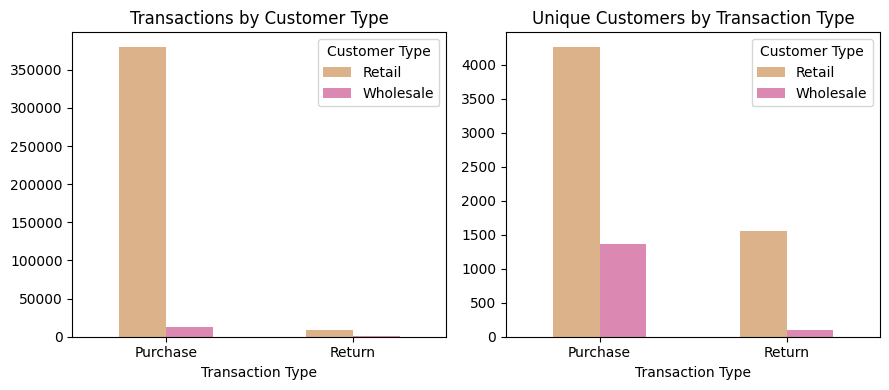

In [19]:
# Convert the grouped Series into a 2D DataFrame with columns for each CustomerType
# After unstack(), each row represents a TransactionType (Purchase/Return),
# and each column represents a CustomerType (Retail/Wholesale), which makes it ready for plotting grouped bar charts.
trans_cс = trans_cust_count.unstack()
cust_tc=cust_trans_count.unstack()

# Create a chart with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(9,4))  


# create subplot with transaction count
trans_cс.plot(kind='bar', ax=axes[0], color=['#DBB289', '#DB89B2'])          
axes[0].set_title('Transactions by Customer Type')
# set horizontal x-axis labels
axes[0].tick_params(axis='x', rotation=0)
axes[0].set_xlabel('Transaction Type')
axes[0].legend(title= 'Customer Type')


# create subplot with unique client count
cust_tc.plot(kind='bar', ax=axes[1], color=['#DBB289', '#DB89B2'])            
axes[1].set_title('Unique Customers by Transaction Type')
# set horizontal x-axis labels
axes[1].tick_params(axis='x', rotation=0)
axes[1].set_xlabel('Transaction Type')
axes[1].legend(title= 'Customer Type')


plt.tight_layout()
plt.show()

After grouping customers by retail vs wholesale, the charts suggest that:
 - Most purchases come from retailer customers.
 - Returns are generally more common among retail customers compared to wholesale.

### 2.2 Retail and Wholesale Price-based Segmentation

In [21]:
# Generate descriptive statistics
gift_cl.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,392692.0,13.119702,1.0,2.0,6.0,12.0,80995.0,180.492832
InvoiceDate,392692,2011-07-10 19:13:07.771892480,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 12:02:00,2011-10-20 12:53:00,2011-12-09 12:50:00,NaN
UnitPrice,392692.0,3.125914,0.001,1.25,1.95,3.75,8142.75,22.241836
TotalPrice,392692.0,22.6315,0.001,4.95,12.45,19.8,168469.6,311.099224


In [20]:
# Check the gift_cl dataframe
print(gift_cl.info())
print("Unique customers:", gift_cl['CustomerID'].nunique())  # unique clients
print("Unique products:", gift_cl['StockCode'].nunique())    # unique items

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392692 entries, 0 to 392691
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  object        
 7   Country      392692 non-null  category      
 8   TotalPrice   392692 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.3+ MB
None
Unique customers: 4338
Unique products: 3665


In [21]:
# Clean the country column for vizualizations
gift_cl['Country'] = gift_cl['Country'].cat.rename_categories({'EIRE': 'Ireland', 'RSA': 'South Africa'})

# Remove unspecified countries
gift_cl = gift_cl[~gift_cl['Country'].isin(['Unspecified', 'European Community'])]

# Use UK only for the further analysis, since 91% of transactions come from UK
gift_uk = gift_cl[gift_cl['Country'] == 'United Kingdom']

gift_uk

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
392672,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804,United Kingdom,23.40
392673,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,23.60
392674,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113,United Kingdom,30.00
392675,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113,United Kingdom,214.80


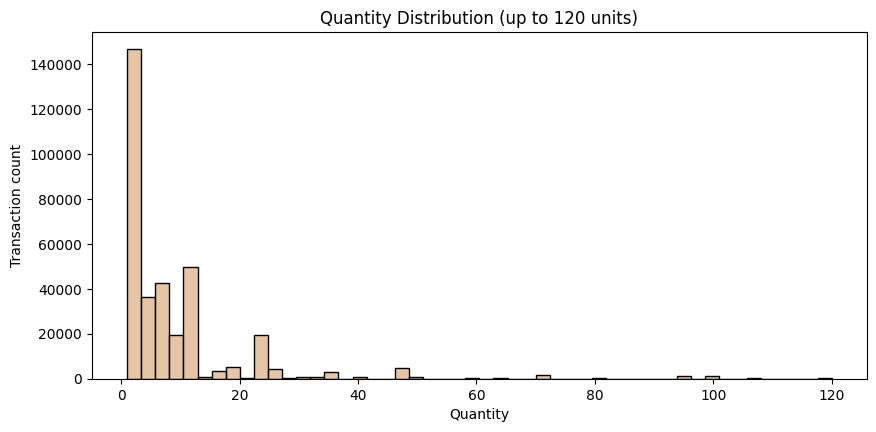

In [22]:
# Create 'Quantity' distribution plot to see which quantities are more frequent
plt.figure(figsize=(10,4.5))

sns.histplot(gift_uk[gift_uk['Quantity'] <= 120]['Quantity'], bins=50, color='#DBB289')

plt.title('Quantity Distribution (up to 120 units)')
plt.xlabel('Quantity')
plt.ylabel('Transaction count')
plt.show()

The majority of transactions are small purchases below 20 units. A long tail extends to much larger quantities which may reflect presence of retail and wholesale orders.

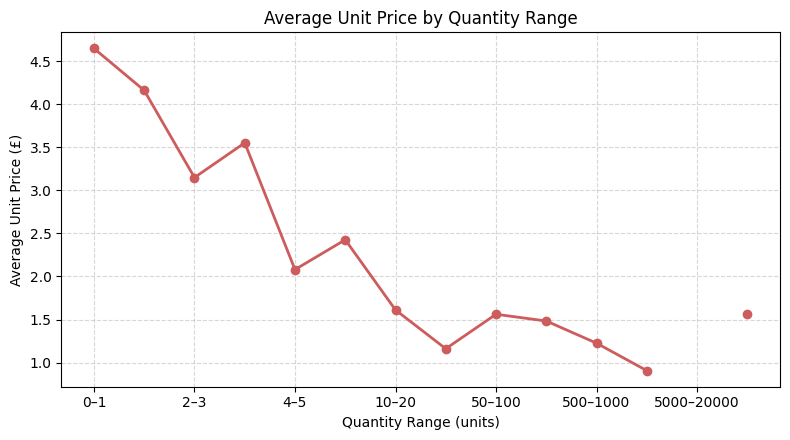

In [23]:
# Plot the average unit price by Quantity
# Assign the bins
bins = [0, 1, 2, 3, 4, 5, 10, 20, 50, 100, 500, 1000, 5000, 20000, 81000]
labels = [f"{bins[i]}–{bins[i+1]}" for i in range(len(bins)-1)]

qbin = pd.cut(gift_uk['Quantity'], bins=bins, labels=labels)

# Aggregate using mean values
price_by_qty = gift_uk.groupby(qbin, observed=False)['UnitPrice'].mean()

plt.figure(figsize=(8, 4.5))
price_by_qty.plot(marker='o', linewidth=2, color='indianred')

plt.xlabel('Quantity Range (units)')
plt.ylabel('Average Unit Price (£)')
plt.title('Average Unit Price by Quantity Range')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

 - Average unit price decreases as transaction quantity increases, reflecting volume discounts.
 - **Price drops** appear around **small to medium quantity** (1-2 and 2-3, 3-4 and 4-5, 10-20 and 20-50).
 - The price gradually stabilizes for larger quantities.
 - The last interval(20 000+) shows an **unusually high price**, likely due to outliers or special cases.

### 2.3 Price Outliers Investigation: Non-Product Transactions

In [24]:
# Check the top unit price values
gift_uk.sort_values(by='UnitPrice', ascending=False).head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
116868,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom,8142.75
266726,569382,M,Manual,1,2011-10-03 16:44:00,3155.95,15502,United Kingdom,3155.95
206437,562946,M,Manual,1,2011-08-11 09:38:00,2500.00,15581,United Kingdom,2500.00
241495,566927,M,Manual,1,2011-09-15 15:20:00,2033.10,17846,United Kingdom,2033.10
100153,549468,M,Manual,1,2011-04-08 14:27:00,1867.86,17940,United Kingdom,1867.86
384883,580727,DOT,DOTCOM POSTAGE,1,2011-12-05 17:17:00,1599.26,14096,United Kingdom,1599.26
370760,579196,DOT,DOTCOM POSTAGE,1,2011-11-28 15:54:00,1526.76,14096,United Kingdom,1526.76
340425,576339,DOT,DOTCOM POSTAGE,1,2011-11-14 15:27:00,1500.36,14096,United Kingdom,1500.36
360764,578270,DOT,DOTCOM POSTAGE,1,2011-11-23 13:39:00,1270.06,14096,United Kingdom,1270.06
331052,575607,DOT,DOTCOM POSTAGE,1,2011-11-10 12:37:00,908.16,14096,United Kingdom,908.16


***
Many of the high priced transactions are actually postage or operational expenses. As they do not bring information about the purchases and could affect the analysis, these transactions will be excluded.
***

In [25]:
# Detect the non-related to sales transactions
# Filter StockCodes that start with a letter (A-Z, case-insensitive)
codes_starting_with_letter = gift_uk[gift_uk['StockCode'].str.match(r'^[A-Za-z]', na=False)]

# See the types of StockCodes
codes_starting_with_letter['StockCode'].value_counts()

StockCode
M               243
C2               30
POST             27
DOT              16
BANK CHARGES     12
PADS              3
Name: count, dtype: int64

In [26]:
# Remove operational codes
operational_codes = ['POST', 'M', 'C2', 'DOT', 'BANK CHARGES', 'PADS']
gift_uk = gift_uk[~gift_uk['StockCode'].isin(operational_codes)]

gift_uk.sort_values(by='UnitPrice', ascending=False).head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
153589,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098,United Kingdom,649.5
153588,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098,United Kingdom,38970.0
76611,546480,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-14 11:38:00,295.0,13452,United Kingdom,295.0
141222,554836,22655,VINTAGE RED KITCHEN CABINET,1,2011-05-26 16:25:00,295.0,13015,United Kingdom,295.0
21089,539080,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-16 08:41:00,295.0,16607,United Kingdom,295.0
31464,540647,22655,VINTAGE RED KITCHEN CABINET,1,2011-01-10 14:57:00,295.0,17406,United Kingdom,295.0
3635,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.0,13145,United Kingdom,295.0
50370,543253,22655,VINTAGE RED KITCHEN CABINET,1,2011-02-04 15:32:00,295.0,14842,United Kingdom,295.0
115042,551393,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-04-28 12:22:00,295.0,14973,United Kingdom,295.0
87714,547814,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-25 14:19:00,295.0,13452,United Kingdom,295.0


### 2.4 Retail and Wholesale Segmentation

Due to a long-tailed distribution of order quantities and ensure that the analysis reflects real purchasing behavior, price breaks will be analyzed  to determine data-driven thresholds separating retail and wholesale orders.

In [27]:
# Conduct price break analysis
from scipy.signal import find_peaks

# Aggregate using mean values
price_by_qty_2 = gift_uk.groupby(qbin, observed=False)['UnitPrice'].mean()

# Find differences in average prices between adjacent bins
diff_price = price_by_qty_2.diff()

breaks_pr = pd.DataFrame({
    'Quantity_bin': price_by_qty_2.index,
    'Avg_Price': price_by_qty_2.values,
    'Price_Change': diff_price.values,
})

# Set the threshold to spot significant drops
# Drops in price = negative differences.
threshold_diff = -0.4

sign_drops_pr = breaks_pr[breaks_pr['Price_Change'] < threshold_diff]

# Find the local min points.

m = np.asarray(price_by_qty_2.values, dtype=float)

# Invert to find peaks = local min
inv_m = -m

# Find the local min indices
local_min_idx, _ = find_peaks(inv_m)

# Get the local min points
local_min_price = breaks_pr.iloc[local_min_idx]

print("\n Local Minimum")
print(local_min_price)


 Local Minimum
  Quantity_bin  Avg_Price  Price_Change
2          2–3   3.149157     -1.013001
4          4–5   2.080551     -1.472787
7        20–50   1.161013     -0.450527


***
The price-break intervals were identified by analyzing how the average unit price changes with increasing order quantity.
The **upper boundary** of each interval marks the point where the next price level begins.  
    
    
Segments:
 - **Retail Level 1**: 1-3 units
 - **Retail Level 2**: 4-5 units
 - **Retail Level 3**: 5-50 units
 - **Wholesale**: 51+ units
 ***

In [28]:
# Retail and wholesale separation into 2 dataframes
# Retail (1–50 units)
gift_r = gift_uk[gift_uk['Quantity'] <= 50].copy()

# Wholesale (51+ units)
gift_w = gift_uk[gift_uk['Quantity'] > 50].copy()

## 3. Cohort Analysis

In [171]:
# Create month column
gift_r['InvoiceMonth'] = gift_r['InvoiceDate'].dt.to_period('M')

# Cohort: first purchase month for each customer
cohort = gift_r.groupby('CustomerID')['InvoiceMonth'].min().rename('CohortMonth')

# Merge back
gift_r = gift_r.merge(cohort, on='CustomerID')
gift_r.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,CohortMonth_x,CohortIndex,CohortMonth_y
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12,2010-12,1,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2010-12,1,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12,2010-12,1,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2010-12,1,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2010-12,1,2010-12


In [30]:
# Extract year and month separately
def get_year_month(col):
    return col.dt.year, col.dt.month

invoice_year, invoice_month = get_year_month(gift_r['InvoiceMonth'])
cohort_year, cohort_month = get_year_month(gift_r['CohortMonth'])

# Calculate cohort index
year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

cohort_index = year_diff*12 + month_diff + 1
gift_r['CohortIndex'] = cohort_index

In [31]:
# Create Cohort Retention Table
# Count active customers in each cohort and return number of unique clients
cohort_data = (gift_r.groupby(['CohortMonth','CohortIndex'])['CustomerID']
             .nunique()
             .reset_index()
)

cohort_p = cohort_data.pivot(index = 'CohortMonth', columns='CohortIndex', values = 'CustomerID').fillna(0).astype(int)

# Calculate retention percents
cohort_size = cohort_p.iloc[:,0] # 1st column = each cohort size (month 1, first purchase)
retention = (cohort_p.divide(cohort_size, axis=0)*100).round(1)

retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,100.0,35.1,32.1,36.5,35.4,39.9,35.1,33.3,34.5,38.9,36.0,49.8,26.1
2011-01,100.0,20.2,26.5,22.8,32.2,27.4,24.8,25.1,29.9,32.5,35.3,12.5,0.0
2011-02,100.0,18.3,20.1,29.0,29.6,25.6,25.3,27.1,27.1,31.4,7.0,0.0,0.0
2011-03,100.0,15.1,25.5,19.7,23.1,16.6,26.7,23.3,27.4,8.9,0.0,0.0,0.0
2011-04,100.0,21.4,20.3,21.0,19.9,22.9,22.5,25.8,7.4,0.0,0.0,0.0,0.0
2011-05,100.0,19.5,17.5,17.1,21.1,23.1,26.7,9.2,0.0,0.0,0.0,0.0,0.0
2011-06,100.0,17.3,13.5,23.6,23.6,32.2,10.1,0.0,0.0,0.0,0.0,0.0,0.0
2011-07,100.0,16.9,21.5,23.8,27.9,11.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-08,100.0,20.9,22.3,24.5,12.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


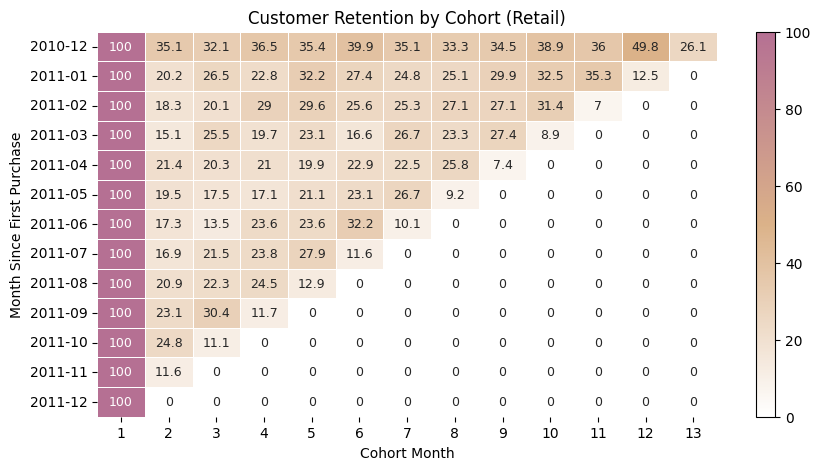

In [32]:
# In case of 1 row only annotation problem
# %pip install seaborn --upgrade
from matplotlib.colors import LinearSegmentedColormap

colors = ['w', '#DBB289', '#b57093']
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Plot heatmap for cohort customer retention
plt.figure(figsize=(10,5))
ax = sns.heatmap(retention, annot=True, fmt='g', cmap=custom_cmap, cbar=False, annot_kws={"size":9}, linewidths=.5)
plt.colorbar(ax.collections[0], ax=ax)

plt.title('Customer Retention by Cohort (Retail)')
plt.xlabel('Cohort Month')
plt.ylabel('Month Since First Purchase')

plt.show()

**Key findings**
 1. **December 2010 Cohort Shows Notably High Retention**    
 The December 2010 cohort stands out with consistently high retention, maintaining 32-50% of customers for many months. This is the only cohort with consistent long-term engagement.
 
 2. **Decline for All Following Months**    
 All later cohorts show lower retention: 15-25% for the second month.
 
 **Overall Insight**       
 Customer retention in the retail segment is generally low, with fast drop-off after the initial purchase. The December 2010 cohort is the only exeption, likely influenced by customer composition, seasonal demand, or external factors.
 
 
 **Business Recommendations**  
- **Boost early-stage engagement**: Add welcome offers to encourage repeat purchases in the first month.
- **Leverage seasonal peaks**: Plan promotions, discounts, and marketing campaigns around key seasonal periods to maximize repeat purchases.
- **Track cohort Trends**: Regularly monitor retention to adjust marketing strategies.

## 4. Predictive Modeling: Repeat Purchase

### 4.1 Feature Engineering (RFM + Behavioral)

In [35]:
# Display and check the dataframe
gift_r

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12,2010-12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2010-12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12,2010-12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2010-12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2010-12,1
...,...,...,...,...,...,...,...,...,...,...,...,...
340356,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804,United Kingdom,23.40,2011-12,2011-05,8
340357,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,23.60,2011-12,2010-12,13
340358,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113,United Kingdom,30.00,2011-12,2010-12,13
340359,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113,United Kingdom,214.80,2011-12,2010-12,13


The dataset contains multiple rows for the same product within the same order, each with different ‘Quantity’ values. Those rows needs to be aggregated before applying ML techniques.

In [33]:
# Aggregate data with items, repeating in the same order
gift_r_agg = gift_r.groupby(['InvoiceNo', 'StockCode'], as_index=False).agg({
    'InvoiceDate': 'min',
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'CustomerID':'first'
})

gift_r_agg['TotalPrice'] = gift_r_agg['UnitPrice'] * gift_r_agg['Quantity']

gift_r_agg.describe().T

,count,mean,min,25%,50%,75%,max,std
InvoiceDate,335653,2011-07-10 22:23:55.224354048,2010-12-01 08:26:00,2011-04-07 11:30:00,2011-07-31 12:02:00,2011-10-21 14:41:00,2011-12-09 12:49:00,NaN
Quantity,335653.0,8.072843,1.0,2.0,4.0,12.0,75.0,9.168484
UnitPrice,335653.0,2.911589,0.06,1.25,1.95,3.75,649.5,4.264313
TotalPrice,335653.0,15.165823,0.06,4.2,10.2,17.7,838.8,20.904677


In [34]:
# Check the resulting dataframe
gift_r_agg.head()

,InvoiceNo,StockCode,InvoiceDate,Quantity,UnitPrice,CustomerID,TotalPrice
0,536365,21730,2010-12-01 08:26:00,6,4.25,17850,25.50
1,536365,22752,2010-12-01 08:26:00,2,7.65,17850,15.30
2,536365,71053,2010-12-01 08:26:00,6,3.39,17850,20.34
3,536365,84029E,2010-12-01 08:26:00,6,3.39,17850,20.34
4,536365,84029G,2010-12-01 08:26:00,6,3.39,17850,20.34


In [35]:
# Set a cutt-off date to separate data for Recency calculation
# Find the date, that is a day later than the last day in the dataframe 
last_date = gift_r_agg['InvoiceDate'].max()
window_days = 45

cutoff_date = last_date - pd.Timedelta(days=window_days)

# Create "past" and "future" dataframes to use the past data in feature engeneering and model training and 
# test it on "future" data
past_gift_r = gift_r_agg[gift_r_agg['InvoiceDate'] <= cutoff_date]
future_gift_r = gift_r_agg[gift_r_agg['InvoiceDate'] > cutoff_date]

past_gift_r

,InvoiceNo,StockCode,InvoiceDate,Quantity,UnitPrice,CustomerID,TotalPrice
0,536365,21730,2010-12-01 08:26:00,6,4.25,17850,25.50
1,536365,22752,2010-12-01 08:26:00,2,7.65,17850,15.30
2,536365,71053,2010-12-01 08:26:00,6,3.39,17850,20.34
3,536365,84029E,2010-12-01 08:26:00,6,3.39,17850,20.34
4,536365,84029G,2010-12-01 08:26:00,6,3.39,17850,20.34
...,...,...,...,...,...,...,...
255814,572661,22960,2011-10-25 12:38:00,6,4.25,17193,25.50
255815,572661,23169,2011-10-25 12:38:00,24,3.75,17193,90.00
255816,572661,23189,2011-10-25 12:38:00,36,2.89,17193,104.04
255817,572661,23293,2011-10-25 12:38:00,48,0.83,17193,39.84


In [36]:
# Aggregate by orders and customers
orders = past_gift_r.groupby(['InvoiceNo', 'CustomerID'], as_index=False).agg({
    'InvoiceDate': 'min',
    'Quantity': 'sum',
    'TotalPrice': 'sum',       # total order price 
    'UnitPrice': 'mean',
    'StockCode': 'nunique'
})

# Create price flags
orders['Expensive'] = (orders['UnitPrice'] > 10).astype(int)
orders['Cheap'] = (orders['UnitPrice'] < 1).astype(int)


# Rename for clarity
orders = orders.rename(columns={
    'Quantity': 'InvoiceQuantity',
    'TotalPrice': 'TotalSum',
    'StockCode': 'UniqueItems',
    'UnitPrice': 'UnitPriceMean'
})

# Add time-related features 
orders['DayOfWeek'] = orders['InvoiceDate'].dt.dayofweek      # 0 = Monday
orders['Hour'] = orders['InvoiceDate'].dt.hour
orders['Month'] = orders['InvoiceDate'].dt.month

orders

,InvoiceNo,CustomerID,InvoiceDate,InvoiceQuantity,TotalSum,UnitPriceMean,UniqueItems,Expensive,Cheap,DayOfWeek,Hour,Month
0,536365,17850,2010-12-01 08:26:00,40,139.12,3.910000,7,0,0,2,8,12
1,536366,17850,2010-12-01 08:28:00,12,22.20,1.850000,2,0,0,2,8,12
2,536367,13047,2010-12-01 08:34:00,83,278.73,4.853333,12,0,0,2,8,12
3,536368,13047,2010-12-01 08:34:00,15,70.05,4.775000,4,0,0,2,8,12
4,536369,13047,2010-12-01 08:35:00,3,17.85,5.950000,1,0,0,2,8,12
...,...,...,...,...,...,...,...,...,...,...,...,...
12482,572655,16708,2011-10-25 12:20:00,285,656.63,3.364444,27,0,0,1,12,10
12483,572657,15615,2011-10-25 12:27:00,166,381.10,4.106667,12,0,0,1,12,10
12484,572658,17690,2011-10-25 12:29:00,91,307.19,4.579474,19,0,0,1,12,10
12485,572660,14527,2011-10-25 12:30:00,50,232.71,4.853810,21,0,0,1,12,10


In [37]:
# Find the date, that is a day later than the last day in the "past" dataframe aggregated by orders
reference_date = cutoff_date + pd.Timedelta(days=1)

# Group data by customer to calculate RFM metrics
rfm = past_gift_r.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',              # Frequency
    'TotalPrice': 'sum'          # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12747,22,9,3444.78
1,12748,2,148,17787.64
2,12749,85,3,2723.73
3,12820,30,2,388.23
4,12821,169,1,92.72


In [38]:
# Price-based features per customer

# Aggregate price information per customer
cust_price_features = orders.groupby('CustomerID').agg({
    'UnitPriceMean' : ['median', 'std'],
    'TotalSum': ['median', 'max', 'std'],
    'InvoiceQuantity': 'mean',
    'UniqueItems': 'mean',
    'Expensive': 'mean',
    'Cheap': 'mean'
})


# Flatten multi-level columns
cust_price_features.columns = [
    'UnitPriceMedian', 'UnitPriceStd', 'OrderValueMedian', 
    'OrderValueMax', 'OrderValueStd', 'QuantityAvg', 
    'UniqueItemsAvg', 'ExpensiveItems', 'CheapItems'
]
cust_price_features.reset_index(inplace=True)

cust_price_features

,CustomerID,UnitPriceMedian,UnitPriceStd,OrderValueMedian,OrderValueMax,OrderValueStd,QuantityAvg,UniqueItemsAvg,ExpensiveItems,CheapItems
0,12747,4.230000,1.343710,347.710,675.38,118.413443,118.888889,9.444444,0.000000,0.000000
1,12748,2.361250,2.098474,52.410,1897.95,222.031306,79.344595,16.054054,0.013514,0.108108
2,12749,4.798193,0.102553,859.100,1834.93,903.604255,335.000000,42.333333,0.000000,0.000000
3,12820,1.695682,0.098031,194.115,217.77,33.453222,181.500000,12.500000,0.000000,0.000000
4,12821,2.498333,NaN,92.720,92.72,NaN,70.000000,6.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
3449,18280,4.765000,NaN,180.600,180.60,NaN,45.000000,10.000000,0.000000,0.000000
3450,18281,5.622857,NaN,80.820,80.82,NaN,54.000000,7.000000,0.000000,0.000000
3451,18282,5.552857,NaN,100.210,100.21,NaN,75.000000,7.000000,0.000000,0.000000
3452,18283,1.653322,0.333124,106.875,192.80,47.534501,71.700000,40.900000,0.000000,0.000000


In [39]:
# Time-based features per customer

# Days between orders feature
# Sort values
orders = orders.sort_values(['CustomerID', 'InvoiceDate'])
# Find the previous date and calculate the difference in days between current and previous date
orders['PrevOrder'] = orders.groupby('CustomerID')['InvoiceDate'].shift(1)
orders['DaysBetween'] = (orders['InvoiceDate'] - orders['PrevOrder']).dt.days


# Last 30 days orders feature
# Cutoff date separates "past" and "future" parts of data
last_30_days = cutoff_date - pd.Timedelta(days=30)

# Count the number of orders in the last 30 days ("past" dataframe)
last_month_orders = (orders[orders['InvoiceDate'] >= last_30_days].groupby('CustomerID').size().rename('LastMonthOrders'))


# Aggregate time information per customer
time_features = orders.groupby('CustomerID').agg({
    'DaysBetween': ['median', 'max'],
    'DayOfWeek': 'median',
    'Month':'median',
    'Hour': 'median'
})

# Rename the columns
time_features.columns = [
    'DaysBetweenMedian', 'DaysBetweenMax', 'DayOfWeekMedian',
    'MonthMedian', 'HourMedian'
]

# Add the last month feature
time_features = time_features.join(last_month_orders, how='left')
# Assign 0 if there is no orders in the last month 
time_features['LastMonthOrders'] = time_features['LastMonthOrders'].fillna(0)


time_features.reset_index(inplace=True)

time_features

,CustomerID,DaysBetweenMedian,DaysBetweenMax,DayOfWeekMedian,MonthMedian,HourMedian,LastMonthOrders
0,12747,39.0,65.0,1.0,6.0,10.0,1.0
1,12748,0.0,30.0,3.0,7.0,14.0,14.0
2,12749,41.0,82.0,0.0,8.0,12.0,0.0
3,12820,251.0,251.0,0.0,5.0,11.5,1.0
4,12821,NaN,NaN,0.0,5.0,15.0,0.0
...,...,...,...,...,...,...,...
3449,18280,NaN,NaN,0.0,3.0,9.0,0.0
3450,18281,NaN,NaN,6.0,6.0,10.0,0.0
3451,18282,NaN,NaN,4.0,8.0,13.0,0.0
3452,18283,22.0,52.0,3.0,5.5,13.0,0.0


In [40]:
# Behavioral features per customer
# 1. Number of items purchased
cust_behav = past_gift_r.groupby('CustomerID')['StockCode'].nunique().reset_index().rename(
    columns={'StockCode': 'TotalUniqueItems'}
)

# 2. Customer 'Age' feature - a difference between the first and the last purchase
first_buy = past_gift_r.groupby('CustomerID')['InvoiceDate'].min()
last_buy = past_gift_r.groupby('CustomerID')['InvoiceDate'].max()

customer_age = (last_buy - first_buy).dt.days.rename('CustomerAge')
# Add customer age to customer features
cust_behav = cust_behav.join(customer_age, on='CustomerID', how='left')

# 3. Purchase Frequency
order_amount = orders.groupby('CustomerID').size().rename('NumOrders')    # number of all orders of the customer

purchase_freq = (order_amount / (customer_age +1)).rename('PurchaseFrequency')    # +1 to avoid division by 0
# Add purchase frequency to customer features
cust_behav = cust_behav.join(purchase_freq, on='CustomerID', how='left')


# 4. Items Repeatability. Amount of items bought by the same customer more that once between the orders
# Number of purchases of each item by customer
item_count = past_gift_r.groupby(['CustomerID', 'StockCode']).size()

# Repeatition amount for unique items
repeat_items = (item_count > 1).groupby('CustomerID').sum()     # number of orders where unique item repeat
total_unique_items = item_count.groupby('CustomerID').size()    # total number of unique items

item_repeat = (repeat_items / total_unique_items).rename('ItemRepeat')

# Add it to customer features
cust_behav = cust_behav.join(item_repeat, on='CustomerID', how='left')
cust_behav['ItemRepeat'] = cust_behav['ItemRepeat'].fillna(0)

cust_behav

,CustomerID,TotalUniqueItems,CustomerAge,PurchaseFrequency,ItemRepeat
0,12747,38,302,0.029703,0.473684
1,12748,1336,326,0.452599,0.423653
2,12749,112,82,0.036145,0.133929
3,12820,25,251,0.007937,0.000000
4,12821,6,0,1.000000,0.000000
...,...,...,...,...,...
3449,18280,10,0,1.000000,0.000000
3450,18281,7,0,1.000000,0.000000
3451,18282,7,0,1.000000,0.000000
3452,18283,191,241,0.041322,0.434555


In [41]:
# Merge all features
cust_class_data = (rfm
                   .merge(cust_price_features, on='CustomerID', how='left')
                   .merge(time_features, on='CustomerID', how='left')
                   .merge(cust_behav, on='CustomerID', how='left')
                  )
cust_class_data

,CustomerID,Recency,Frequency,Monetary,UnitPriceMedian,UnitPriceStd,OrderValueMedian,OrderValueMax,OrderValueStd,QuantityAvg,...,DaysBetweenMedian,DaysBetweenMax,DayOfWeekMedian,MonthMedian,HourMedian,LastMonthOrders,TotalUniqueItems,CustomerAge,PurchaseFrequency,ItemRepeat
0,12747,22,9,3444.78,4.230000,1.343710,347.710,675.38,118.413443,118.888889,...,39.0,65.0,1.0,6.0,10.0,1.0,38,302,0.029703,0.473684
1,12748,2,148,17787.64,2.361250,2.098474,52.410,1897.95,222.031306,79.344595,...,0.0,30.0,3.0,7.0,14.0,14.0,1336,326,0.452599,0.423653
2,12749,85,3,2723.73,4.798193,0.102553,859.100,1834.93,903.604255,335.000000,...,41.0,82.0,0.0,8.0,12.0,0.0,112,82,0.036145,0.133929
3,12820,30,2,388.23,1.695682,0.098031,194.115,217.77,33.453222,181.500000,...,251.0,251.0,0.0,5.0,11.5,1.0,25,251,0.007937,0.000000
4,12821,169,1,92.72,2.498333,NaN,92.720,92.72,NaN,70.000000,...,NaN,NaN,0.0,5.0,15.0,0.0,6,0,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3449,18280,233,1,180.60,4.765000,NaN,180.600,180.60,NaN,45.000000,...,NaN,NaN,0.0,3.0,9.0,0.0,10,0,1.000000,0.000000
3450,18281,136,1,80.82,5.622857,NaN,80.820,80.82,NaN,54.000000,...,NaN,NaN,6.0,6.0,10.0,0.0,7,0,1.000000,0.000000
3451,18282,81,1,100.21,5.552857,NaN,100.210,100.21,NaN,75.000000,...,NaN,NaN,4.0,8.0,13.0,0.0,7,0,1.000000,0.000000
3452,18283,51,10,1080.88,1.653322,0.333124,106.875,192.80,47.534501,71.700000,...,22.0,52.0,3.0,5.5,13.0,0.0,191,241,0.041322,0.434555


In [42]:
# Create Target variable (0- customer will not return, 1-customer will return)

# Dataframe for a target variable. All customers who made a purchase after cut-off date
returned_cust = future_gift_r.groupby('CustomerID').size().reset_index(name='Returned')
returned_cust['Returned'] = 1     # assign 1 to all returned customers


# Merge target with features
cust_class_data = cust_class_data.merge(returned_cust[['CustomerID', 'Returned']], on='CustomerID', how='left')

# Fill in the gaps in 'Returned' with 0. Only returned customers got 1 earlier.
# After the merge the rest of the customers have NaN in 'Returned'
cust_class_data['Returned'] = cust_class_data['Returned'].fillna(0).astype(int)

cust_class_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         3454 non-null   object 
 1   Recency            3454 non-null   int64  
 2   Frequency          3454 non-null   int64  
 3   Monetary           3454 non-null   float64
 4   UnitPriceMedian    3454 non-null   float64
 5   UnitPriceStd       2081 non-null   float64
 6   OrderValueMedian   3454 non-null   float64
 7   OrderValueMax      3454 non-null   float64
 8   OrderValueStd      2081 non-null   float64
 9   QuantityAvg        3454 non-null   float64
 10  UniqueItemsAvg     3454 non-null   float64
 11  ExpensiveItems     3454 non-null   float64
 12  CheapItems         3454 non-null   float64
 13  DaysBetweenMedian  2081 non-null   float64
 14  DaysBetweenMax     2081 non-null   float64
 15  DayOfWeekMedian    3454 non-null   float64
 16  MonthMedian        3454 

In [43]:
# Check the data for missing values
cust_class_data.isna().sum()

CustomerID              0
Recency                 0
Frequency               0
Monetary                0
UnitPriceMedian         0
UnitPriceStd         1373
OrderValueMedian        0
OrderValueMax           0
OrderValueStd        1373
QuantityAvg             0
UniqueItemsAvg          0
ExpensiveItems          0
CheapItems              0
DaysBetweenMedian    1373
DaysBetweenMax       1373
DayOfWeekMedian         0
MonthMedian             0
HourMedian              0
LastMonthOrders         0
TotalUniqueItems        0
CustomerAge             0
PurchaseFrequency       0
ItemRepeat              0
Returned                0
dtype: int64

In [44]:
# Fill std deviations with 0
std_cols = ['UnitPriceStd', 'OrderValueStd']
cust_class_data[std_cols] = cust_class_data[std_cols].fillna(0)

# Fill days-between orders with mean
days_cols = ['DaysBetweenMedian', 'DaysBetweenMax']
for col in days_cols:
    cust_class_data[col] = cust_class_data[col].fillna(cust_class_data[col].mean())

cust_class_data.isna().sum()

CustomerID           0
Recency              0
Frequency            0
Monetary             0
UnitPriceMedian      0
UnitPriceStd         0
OrderValueMedian     0
OrderValueMax        0
OrderValueStd        0
QuantityAvg          0
UniqueItemsAvg       0
ExpensiveItems       0
CheapItems           0
DaysBetweenMedian    0
DaysBetweenMax       0
DayOfWeekMedian      0
MonthMedian          0
HourMedian           0
LastMonthOrders      0
TotalUniqueItems     0
CustomerAge          0
PurchaseFrequency    0
ItemRepeat           0
Returned             0
dtype: int64

**Final dataset for CatBoost contains:**

 - RFM features: Recency, Frequency, Monetary
 - Price-based features: Unit Price and Order information, Expensive/Cheap Items
 - Time-related features: Days Between Orders information, Last Month Orders, Median of Hour, Month, Day
 - Behavioral features: Total Number of Unique Items, Customer Age, Purchase Frequency, Item Repeatability
 - Target variable: Returned

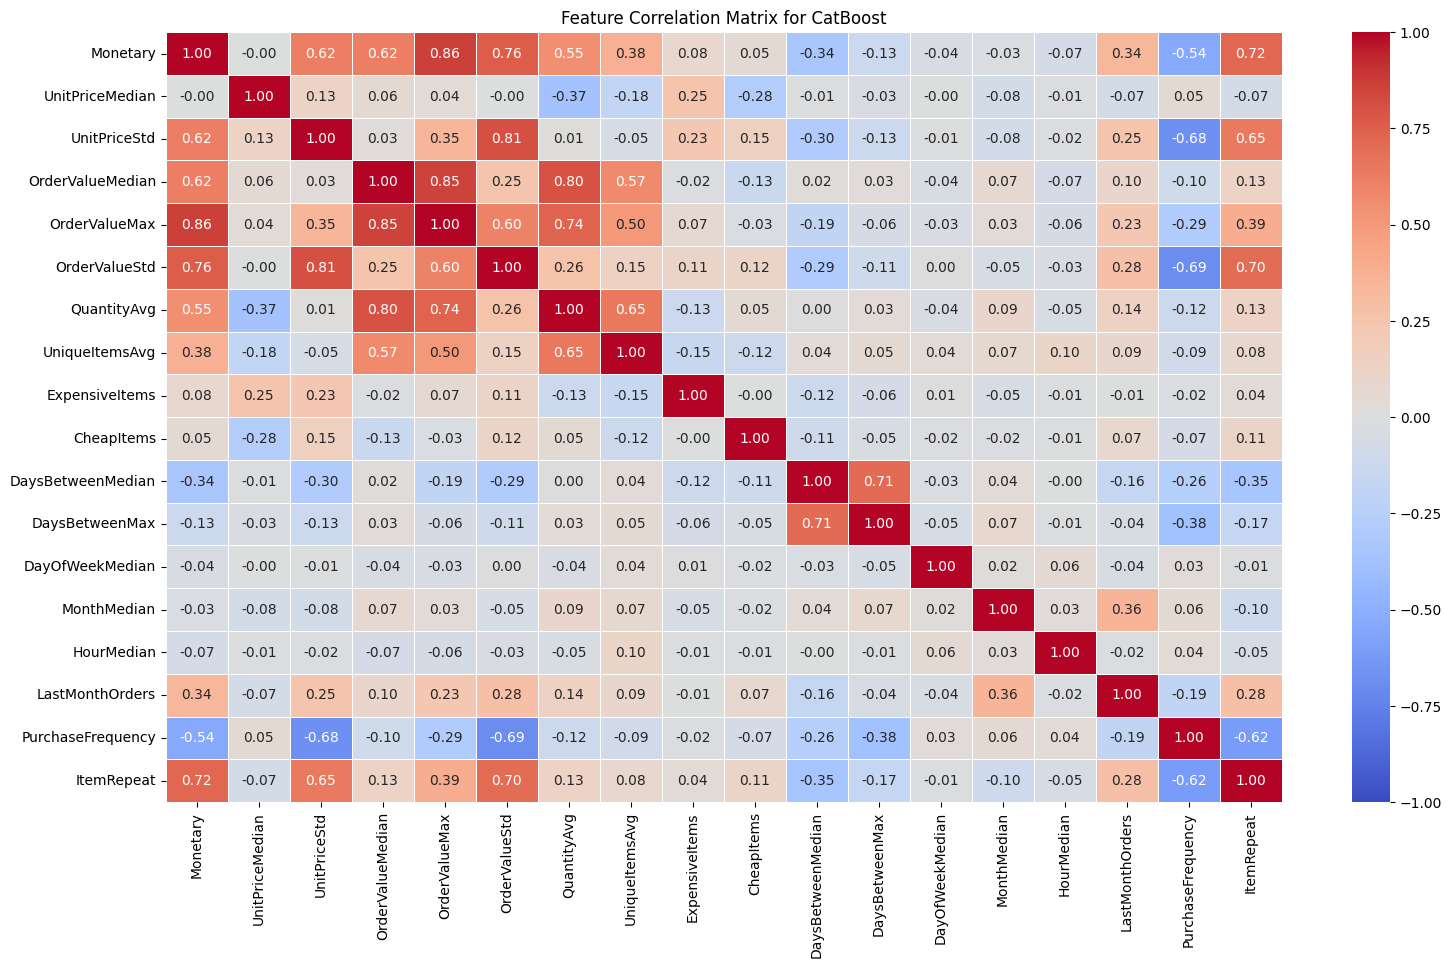

In [45]:
# Check feature correlations before applying CatBoost (Spearman)
plt.figure(figsize=(18,10))

numeric_cols = cust_class_data.select_dtypes(include='float64').columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['Returned']]

corr_matrix_spearman = cust_class_data[numeric_cols].corr(method='spearman')
sns.heatmap(corr_matrix_spearman, annot=True, fmt=".2f", cmap='coolwarm', vmax=1.0, vmin=-1.0, 
            center=0, linewidths=.5)
plt.title('Feature Correlation Matrix for CatBoost')
plt.show()

**Highly correlated** features (e.g., 'UnitPriceAvg', 'OrderValueAvg', 'DayOfYearMedian') were **removed** to reduce redundancy and improve interpretability.  
Remaining features with moderate correlations, such as `Monetary`, `OrderValueMax`, and `ItemRepeat`, were kept in the data because they capture distinct customer behaviors and purchasing patterns for the CatBoost model.

### 4.2 Model Training (CatBoost)

CatBoost was chosen as it works effectively with transactional data with mixed numerical and categorical features. The model handles complex customer behavior patterns well and provides a good balance between predictive performance and interpretability for marketing use cases.

In [46]:
# Define features and target variable
X = cust_class_data.drop(columns=['CustomerID', 'Returned'])
y = cust_class_data['Returned']

In [50]:
# %pip install catboost

In [47]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 18, stratify=y)


# Create model considering imbalance of classes
# scale_pos_weight = N_0 / N_1
n0 = sum(y_train == 0)
n1 = sum(y_train == 1)
scale_pos_weight = n0 / n1


# Initialize the model
cust_model_balanced= CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=4,
    eval_metric='AUC',
    l2_leaf_reg= 5,
    random_seed=18,
    verbose=100,
    class_weights=[1, scale_pos_weight]
)

# Fit the model
cust_model_balanced.fit(X_train, y_train, eval_set=(X_test, y_test))

# Predict classes
y_pred= cust_model_balanced.predict(X_test)
y_proba = cust_model_balanced.predict_proba(X_test)[:,1]

# Display the metrics
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Evaluate the results
y_train_proba = cust_model_balanced.predict_proba(X_train)[:,1]
print("Train AUC:", roc_auc_score(y_train, y_train_proba))

# Best parameters: {'iterations': 300, 'depth': 4, 'learning_rate': 0.05, 'l2_leaf_reg': 5} Best AUC: 0.7778408993096799

0:	test: 0.7382422	best: 0.7382422 (0)	total: 144ms	remaining: 42.9s
100:	test: 0.7791492	best: 0.7792267 (99)	total: 478ms	remaining: 941ms
200:	test: 0.7785984	best: 0.7792525 (102)	total: 810ms	remaining: 399ms
299:	test: 0.7783487	best: 0.7811462 (251)	total: 1.11s	remaining: 0us

bestTest = 0.7811461723
bestIteration = 251

Shrink model to first 252 iterations.
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       402
           1       0.69      0.62      0.65       289

    accuracy                           0.73       691
   macro avg       0.72      0.71      0.71       691
weighted avg       0.72      0.73      0.72       691

AUC: 0.7811461722529223
Confusion matrix:
 [[323  79]
 [111 178]]
Train AUC: 0.8468383192263789


Best threshold (F1): 0.3851652719035139
Best F1 score: 0.6755952331930715


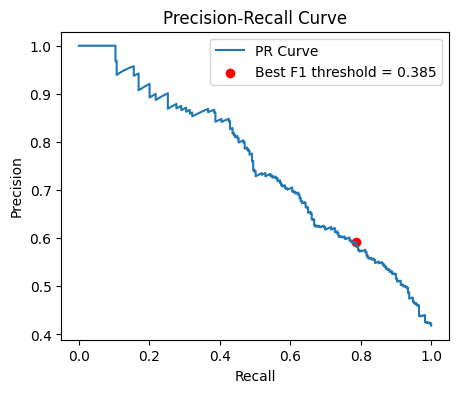

In [48]:
# Choose a threshold using Precision-Recall curve

from sklearn.metrics import precision_recall_curve, f1_score

# Calculate precision, recall and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Find the best threshold on F1-score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_threshold_f1 = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print("Best threshold (F1):", best_threshold_f1)
print("Best F1 score:", best_f1)

# Plot the Precision-Recall curve to see the threshold
plt.figure(figsize=(5, 4))
plt.plot(recall, precision, label="PR Curve")
plt.scatter(recall[np.argmax(f1_scores)],
            precision[np.argmax(f1_scores)],
            color="red",
            label=f"Best F1 threshold = {best_threshold_f1:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [49]:
# Apply new threshold
y_pred_new = (y_proba >= best_threshold_f1).astype(int)

# Check the metrics
print("Classification report:\n", classification_report(y_test, y_pred_new))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_new))
print("AUC:", roc_auc_score(y_test, y_proba))

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.61      0.69       402
           1       0.59      0.79      0.68       289

    accuracy                           0.68       691
   macro avg       0.70      0.70      0.68       691
weighted avg       0.71      0.68      0.69       691

Confusion matrix:
 [[246 156]
 [ 62 227]]
AUC: 0.7811461722529223


***
### 4.3 Model Evaluation & Insights
  
  
 - The CatBoost model was trained to predict whether a customer will make a repeat purchase. Overall, it shows **moderate predictive performance**, with an **accuracy of 73% and AUC of 0.78**, showing reasonable ability to predict whether a customer will return.  
 - After tuning the decision threshold based on the F1-score, the model achieves a **higher recall for repeat buyers (0.79)**, though at the cost of lower recall for non-repeat buyers (0.61). This trade-off highlights that the model is more effective at identifying potential returning customers than at excluding non-returning ones.  
 - The model produces some **false positives** (customers predicted to return but do not) and **false negatives** (customers predicted not to return but do). Awareness of these errors is important for planning marketing actions, as some resources may be spent on non-returning customers while some repeat buyers might be missed.  
  
**Business Insights:** 
 - By targeting the **customers identified** as likely **repeat** buyers, marketing efforts and loyalty initiatives can be more **efficiently directed**, potentially increasing retention and repeat sales.
 
 


**Model Setup**  
  
CatBoost was trained to predict whether a customer will make a repeat purchase.  
Features included:  
- **RFM metrics:** Recency, Frequency, Monetary  
- **Price- and order-related metrics:** Unit price, order quantity, expensive/cheap item flags  
- **Time features:** Days between orders, last month orders, median of hour/month/day  
- **Behavioral features:** Total number of unique items, customer age, purchase frequency, item repeatability  

***

**Performance Before Threshold Tuning (default 0.5)**
- **Accuracy:** 0.73  
- **AUC:** 0.78  
- **Precision / Recall / F1-score:**  
  - Non-repeat buyers (class 0): 0.74 / 0.80 / 0.77  
  - Repeat buyers (class 1): 0.69 / 0.62 / 0.65  
- **Confusion Matrix:**  
 [323  79]  
 [111 178]  
- **Interpretation:** The model reasonably separates repeat from non-repeat buyers, but recall for repeat buyers is moderate (0.62), meaning some repeat buyers are missed.

***

**Performance After Threshold Tuning (optimized for F1-score)**
- **Accuracy:** 0.68  
- **AUC:** 0.78  
- **Precision / Recall / F1-score:**  
  - Non-repeat buyers (class 0): 0.80 / 0.61 / 0.69  
  - Repeat buyers (class 1): 0.59 / 0.79 / 0.68  
- **Confusion Matrix:**  
 [246 156]  
 [ 62 227]  
- **Interpretation:** After tuning, recall for repeat buyers increased to 0.79 (better identification of likely returning customers), while recall for non-repeat buyers dropped to 0.61. This trade-off emphasizes targeting repeat buyers for marketing.

***

### Business Insights
- Marketing and loyalty initiatives can focus on customers predicted as likely repeat buyers to increase retention and repeat sales.  
- Some false positives (customers predicted to return but do not) and false negatives (customers predicted not to return but do) are inevitable, but awareness of these errors helps plan marketing resources efficiently.

In [174]:
# Check the feature importance
cust_model_balanced.get_feature_importance(type='PredictionValuesChange', prettified=True)

,Feature Id,Importances
0,Recency,11.639009
1,TotalUniqueItems,9.662454
2,Frequency,8.132489
3,Monetary,5.856086
4,DaysBetweenMedian,5.475392
5,UniqueItemsAvg,5.175645
6,HourMedian,5.146434
7,OrderValueMedian,4.978190
8,ItemRepeat,4.900528
9,QuantityAvg,4.794970


## 5. Product Co-Purchases & Communities

### 5.1 Market Basket Analysis (FP-Growth)

In [62]:
# # Install mlxtend library if needed
# import sys
# sys.executable

# %pip install mlxtend

In [51]:
from mlxtend.preprocessing import TransactionEncoder

# Preparing data for FP-Growth

# Create list of lists with all items in order baskets
gift_order_lists = gift_r_agg.groupby('InvoiceNo')['StockCode'].apply(list).tolist()

# Transaction Encoder collects all unique items and creates items x basket matrix.
# In the matrix: rows - baskets (InvoiceNo); columns - unique items (StockCode); values - True/False (is item in the basket).
# Create an object TransactionEncoder
te_gift = TransactionEncoder()
te_gift_array = te_gift.fit(gift_order_lists).transform(gift_order_lists)


# Transform the array into dataframe
# Use te_gift.columns_ (not DataFrame .columns) because TransactionEncoder stores
# item names learned during fit() in this attribute, following sklearn naming conventions.
gift_order_df = pd.DataFrame(te_gift_array, columns=te_gift.columns_)

gift_order_df

,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15858,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15859,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15860,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15861,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [52]:
from mlxtend.frequent_patterns import fpgrowth, association_rules

# Sets of items that apear in at least 1% of baskets (min_support = 0.01)
frequent_sets = fpgrowth(gift_order_df, min_support=0.01, use_colnames=True)    # "use_colnames=True" to get the StockCodes instead of numerical indices

# Add length of item sets
frequent_sets['length'] = frequent_sets['itemsets'].apply(len)
# # Check the sets length (optional)
# frequent_sets['length'].value_counts()

# Apply the assosiation rules
rules_full = association_rules(frequent_sets, metric='lift', min_threshold=1.2)     # "min_threshold=1.0" choose only lift >= 1

# Filter the rules by leverage
rules_full = rules_full[(rules_full['leverage'] > 0.002)]
# Remove inverted duplicates: A-B and B-A 
rules_full['pair'] = rules_full.apply(lambda x: frozenset(x['antecedents'] | x['consequents']), axis=1)

rules_full = rules_full.drop_duplicates(subset='pair')

# Sort the results
rules_full=rules_full.sort_values(by=['lift', 'leverage'], ascending=False)
# Get the main rules
rules = rules_full[['antecedents', 'consequents', 'support', 'lift', 'leverage']].copy()

rules.head(10)

,antecedents,consequents,support,lift,leverage
806,(22916),(22917),0.010591,83.176779,0.010463
812,(22916),(22918),0.010339,82.572589,0.010213
810,(22917),(22918),0.010402,82.153013,0.010275
820,(22920),(22918),0.010149,81.520093,0.010025
816,(22920),(22917),0.010275,81.157219,0.010149
822,(22920),(22916),0.010149,81.062115,0.010024
814,(22918),(22919),0.010339,79.880005,0.010209
804,(22917),(22919),0.010465,79.506582,0.010333
818,(22920),(22919),0.010212,78.905859,0.010083
808,(22916),(22919),0.010212,78.462567,0.010082


In [53]:
# codes = ['23172', '23172', '22919', '22918', '22920']
gift_r[gift_r['StockCode'].isin(['22697', '22423', '22699'])].Description.value_counts()

Description
REGENCY CAKESTAND 3 TIER            1398
ROSES REGENCY TEACUP AND SAUCER      675
GREEN REGENCY TEACUP AND SAUCER      613
Name: count, dtype: int64

In [170]:
# Check the first 10 rules

# Choose the rules
first10 = rules.head(10)

# Join antedecedents and consequents into a set to get all unique StockCodes
unique_codes = set()
for idx, row in first10.iterrows():
    unique_codes.update(row['antecedents'])
    unique_codes.update(row['consequents'])

# Transform into a list
unique_codes = list(unique_codes)

# Display the unique stock codes from the first 10 rows
gift_r[gift_r['StockCode'].isin(unique_codes)].Description.value_counts()

Description
HERB MARKER MINT        187
HERB MARKER THYME       183
HERB MARKER ROSEMARY    181
HERB MARKER PARSLEY     180
HERB MARKER BASIL       179
Name: count, dtype: int64

The first 10 rows show us 5 items that are very similar to each other and contain Herb Markers for different types of herbs.

In [55]:
# Add the Descriptions to results to get the meaning behind the codes

# Create a dictionary with codes and descriptions
descr = gift_r[['StockCode', 'Description']].drop_duplicates().set_index('StockCode')['Description'].to_dict()

# Add the descriptions to antecedents and consequents
rules['ante_descr'] = rules['antecedents'].apply(lambda x: ', '.join(descr[i] for i in x))
rules['conseq_descr'] = rules['consequents'].apply(lambda x: ', '.join(descr[i] for i in x))

# Create shorted versions of descriptions for graphs
def short_descr(text, n_words=2):
    return ' '.join(text.split()[:n_words])

rules['ant_descr_c'] = rules['antecedents'].apply(lambda x: ', '.join(f"{i}: {short_descr(descr[i])}" for i in x))
rules['cons_descr_c'] = rules['consequents'].apply(lambda x: ', '.join(f"{i}: {short_descr(descr[i])}" for i in x))

rules.head(13)

,antecedents,consequents,support,lift,leverage,ante_descr,conseq_descr,ant_descr_c,cons_descr_c
806,(22916),(22917),0.010591,83.176779,0.010463,HERB MARKER THYME,HERB MARKER ROSEMARY,22916: HERB MARKER,22917: HERB MARKER
812,(22916),(22918),0.010339,82.572589,0.010213,HERB MARKER THYME,HERB MARKER PARSLEY,22916: HERB MARKER,22918: HERB MARKER
810,(22917),(22918),0.010402,82.153013,0.010275,HERB MARKER ROSEMARY,HERB MARKER PARSLEY,22917: HERB MARKER,22918: HERB MARKER
820,(22920),(22918),0.010149,81.520093,0.010025,HERB MARKER BASIL,HERB MARKER PARSLEY,22920: HERB MARKER,22918: HERB MARKER
816,(22920),(22917),0.010275,81.157219,0.010149,HERB MARKER BASIL,HERB MARKER ROSEMARY,22920: HERB MARKER,22917: HERB MARKER
822,(22920),(22916),0.010149,81.062115,0.010024,HERB MARKER BASIL,HERB MARKER THYME,22920: HERB MARKER,22916: HERB MARKER
814,(22918),(22919),0.010339,79.880005,0.010209,HERB MARKER PARSLEY,HERB MARKER MINT,22918: HERB MARKER,22919: HERB MARKER
804,(22917),(22919),0.010465,79.506582,0.010333,HERB MARKER ROSEMARY,HERB MARKER MINT,22917: HERB MARKER,22919: HERB MARKER
818,(22920),(22919),0.010212,78.905859,0.010083,HERB MARKER BASIL,HERB MARKER MINT,22920: HERB MARKER,22919: HERB MARKER
808,(22916),(22919),0.010212,78.462567,0.010082,HERB MARKER THYME,HERB MARKER MINT,22916: HERB MARKER,22919: HERB MARKER


In [56]:
# Filter the most strong (lift) and the most common (leverage) connections for visualization

rules_filt = rules[rules['lift'] > 15]
rules_filt = rules_filt[rules_filt['leverage'] > 0.013]
# Sort values
rules_filt = rules_filt.sort_values(by=['lift', 'leverage'], ascending=False)
# Assign the rank
rules_filt['rank'] = range(1, len(rules_filt)+1)


rules_filt[['ante_descr', 'conseq_descr', 'support', 'lift', 'leverage', 'rank']]

,ante_descr,conseq_descr,support,lift,leverage,rank
904,BLUE HAPPY BIRTHDAY BUNTING,PINK HAPPY BIRTHDAY BUNTING,0.013617,36.481421,0.013243,1
640,BATHROOM METAL SIGN,TOILET METAL SIGN,0.013680,33.340478,0.013269,2
878,WOODEN HEART CHRISTMAS SCANDINAVIAN,WOODEN STAR CHRISTMAS SCANDINAVIAN,0.018282,27.941387,0.017627,3
788,FELTCRAFT PRINCESS CHARLOTTE DOLL,FELTCRAFT PRINCESS LOLA DOLL,0.013491,27.769723,0.013005,4
988,"PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY ...",GREEN REGENCY TEACUP AND SAUCER,0.020992,23.384119,0.020095,5
962,"REGENCY CAKESTAND 3 TIER, PINK REGENCY TEACUP ...",GREEN REGENCY TEACUP AND SAUCER,0.014121,22.802197,0.013502,6
774,SPACEBOY LUNCH BOX,DOLLY GIRL LUNCH BOX,0.019101,21.635648,0.018218,7
956,PINK REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.025090,21.507760,0.023923,8
968,"REGENCY CAKESTAND 3 TIER, ROSES REGENCY TEACUP...",PINK REGENCY TEACUP AND SAUCER,0.013743,20.744904,0.013080,9
832,"REGENCY CAKESTAND 3 TIER, ROSES REGENCY TEACUP...",GREEN REGENCY TEACUP AND SAUCER,0.016201,19.678291,0.015378,10


Connections from the `'rules_filt'` dataframe will be visualized using 2 network graphs. Data that will be split based on lift values for this purpose.

In [57]:
# Check the minimum Support to get more common sets that better represent the customer behaviour

# # Get the minimum Support value and the total number of orders (optional) 
print("Minimum Percent of a Set Appearance in Baskets among the Top Sets:", round(rules_filt.support.min(), 4)*100, '%')
# print("Number of Unique Orders:", gift_r_agg['InvoiceNo'].nunique())

# Calculate the percent and  of appearance in baskets and 
print("Each Set Appears In At Least:", 
      round((round(rules_filt.support.min(), 4))*gift_r_agg['InvoiceNo'].nunique()), 
      "out of", 
      gift_r_agg['InvoiceNo'].nunique(), 
      "orders")

Minimum Percent of a Set Appearance in Baskets among the Top Sets: 1.35 %
Each Set Appears In At Least: 214 out of 15863 orders


In [58]:
import networkx as nx
# Create a dataframe for visualization
graph_df = rules_filt[['ant_descr_c', 'cons_descr_c', 'lift', 'rank']].copy()
graph_df.rename(columns={'ant_descr_c':'source', 'cons_descr_c':'target', 'lift':'weight'}, inplace=True)

# Separate dataframe into strong and moderate connections
graph_df_s = graph_df[graph_df['weight'] >= 19.0]
graph_df_m = graph_df[graph_df['weight'] < 19.0]



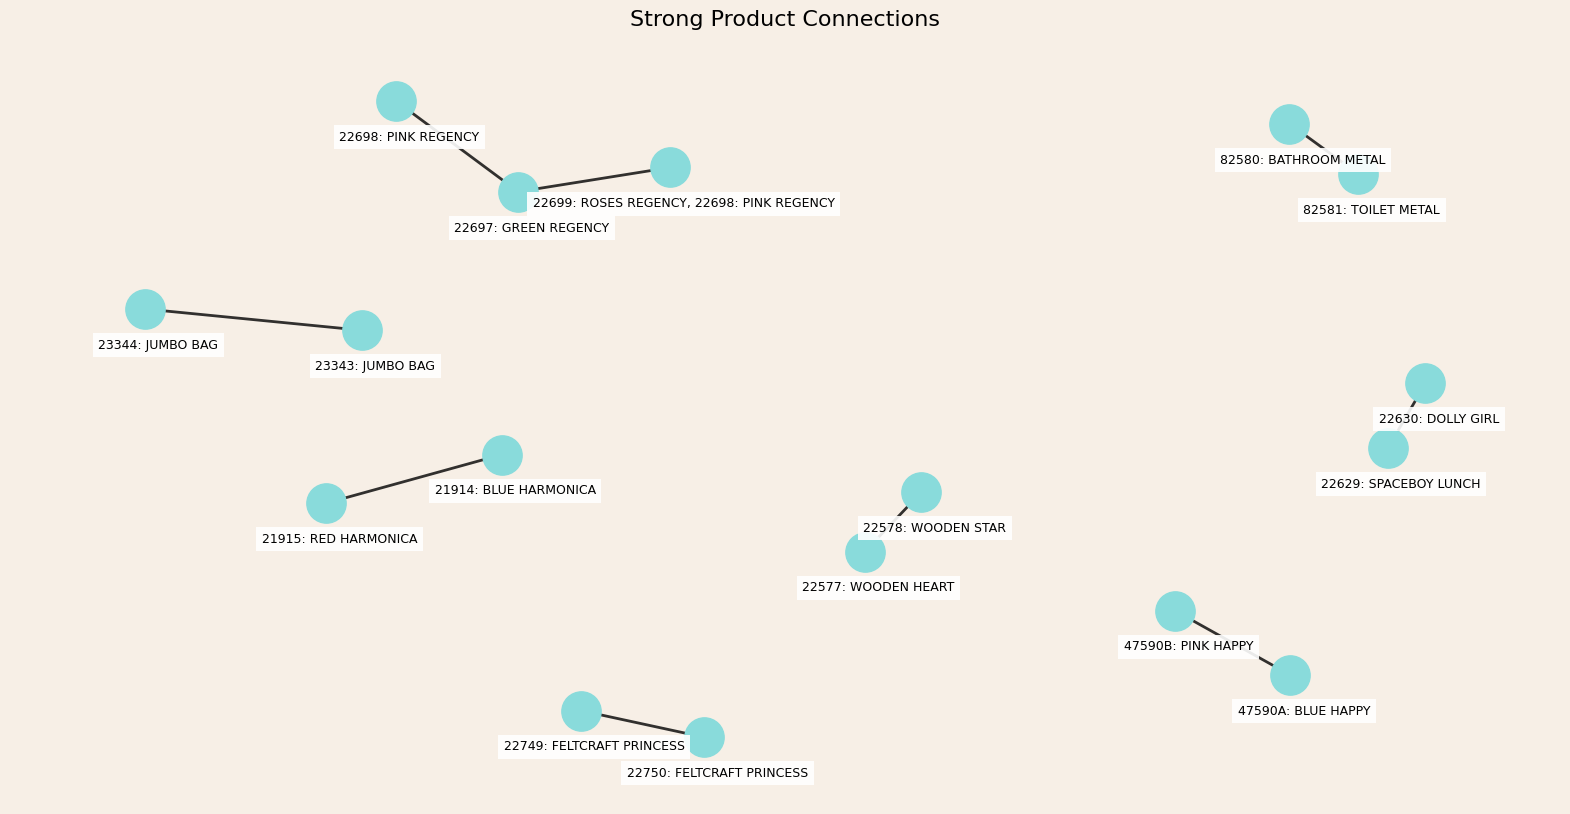

In [73]:
# Build a network graph to visualize connections between the products

plt.figure(figsize=(20, 10), facecolor="#f7efe6")
G_1 = nx.from_pandas_edgelist(graph_df_s, 'source', 'target', edge_attr='weight', create_using=nx.Graph())

# Set nodes positions and create nodes
pos = nx.spring_layout(G_1, k=0.5, seed=18, iterations=10)
nx.draw_networkx_nodes(G_1, pos, node_color='#89dbdb', node_size=800)

# Create edges
edges = G_1.edges()
nx.draw_networkx_edges(G_1, pos, width=2, alpha=0.8)
# Lable edges
pos_lab = {node: (x + 0.02, y - 0.11) for node, (x, y) in pos.items()}
nx.draw_networkx_labels(G_1, pos_lab, font_size=9, bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))

plt.title("Strong Product Connections", fontsize=16)
plt.axis('off')
plt.show()

Node labels contain shortened product descriptions, the table with full product names shows full versions.

In [59]:
# Create a table with full node descriptions
table_1 = rules_filt[rules_filt['lift'] >= 19.0][['rank','ant_descr_c', 'ante_descr', 
                                     'cons_descr_c', 'conseq_descr']].rename(
    columns={'ant_descr_c': 'Node label on graph (A)', 
             'cons_descr_c': 'Node label on graph (C)', 
             'ante_descr':'Full product description (A)',
             'conseq_descr':'Full product description (C)'}).set_index('rank')

table_1.index.name = None
table_1

,Node label on graph (A),Full product description (A),Node label on graph (C),Full product description (C)
1,47590A: BLUE HAPPY,BLUE HAPPY BIRTHDAY BUNTING,47590B: PINK HAPPY,PINK HAPPY BIRTHDAY BUNTING
2,82580: BATHROOM METAL,BATHROOM METAL SIGN,82581: TOILET METAL,TOILET METAL SIGN
3,22577: WOODEN HEART,WOODEN HEART CHRISTMAS SCANDINAVIAN,22578: WOODEN STAR,WOODEN STAR CHRISTMAS SCANDINAVIAN
4,22749: FELTCRAFT PRINCESS,FELTCRAFT PRINCESS CHARLOTTE DOLL,22750: FELTCRAFT PRINCESS,FELTCRAFT PRINCESS LOLA DOLL
5,"22698: PINK REGENCY, 22699: ROSES REGENCY","PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY ...",22697: GREEN REGENCY,GREEN REGENCY TEACUP AND SAUCER
6,"22423: REGENCY CAKESTAND, 22698: PINK REGENCY","REGENCY CAKESTAND 3 TIER, PINK REGENCY TEACUP ...",22697: GREEN REGENCY,GREEN REGENCY TEACUP AND SAUCER
7,22629: SPACEBOY LUNCH,SPACEBOY LUNCH BOX,22630: DOLLY GIRL,DOLLY GIRL LUNCH BOX
8,22698: PINK REGENCY,PINK REGENCY TEACUP AND SAUCER,22697: GREEN REGENCY,GREEN REGENCY TEACUP AND SAUCER
9,"22423: REGENCY CAKESTAND, 22699: ROSES REGENCY","REGENCY CAKESTAND 3 TIER, ROSES REGENCY TEACUP...",22698: PINK REGENCY,PINK REGENCY TEACUP AND SAUCER
10,"22423: REGENCY CAKESTAND, 22699: ROSES REGENCY","REGENCY CAKESTAND 3 TIER, ROSES REGENCY TEACUP...",22697: GREEN REGENCY,GREEN REGENCY TEACUP AND SAUCER


**Table 1. Strong Product Connections. Node Descriptions**

**Key Findings:**
- **7 out of the 8  strongest connections** have only 2 products (pairs of nodes where each contains single product). These pairs are **logically similar** items, that slightly vary by:
    - **Color / Design**: Blue & Pink Bunting, Blue & Red Harmonica, 
    - **Application / Use**: Toilet & Bathroom Sign,
    - **Type**: Wooden Heart & Star, Charlotte Doll & Lola Doll.

- The **largest connected component** consists of **tea-related products**, including teacups, saucers, cake stands in different colors. These items form a dense group, showing that customers often ourchase them together.

**Business insights:**
1. **Bundle-selling Opportunities**
    - Products with strong connections can be sold in **bundles or sets**, e.g. Blue & Pink Bunting, or tea sets including REGENCY tea products.
2. **Personalized Product Recommendations**
    - When a customer views one product, items from the same group can be **suggested**
    - Example: Viewing GREEN REGENCY TEACUP AND SAUCER - recommend PINK REGENCY TEACUP AND SAUCER or REGENCY CAKESTAND 3 TIER
3. **Promotions**
    - Seasonal campaigns can target **logically connected products** to increase average order value
4. **Category Segmentation**
    - Strong products assosiations reflect related segments, helping plan promotions and stock management.

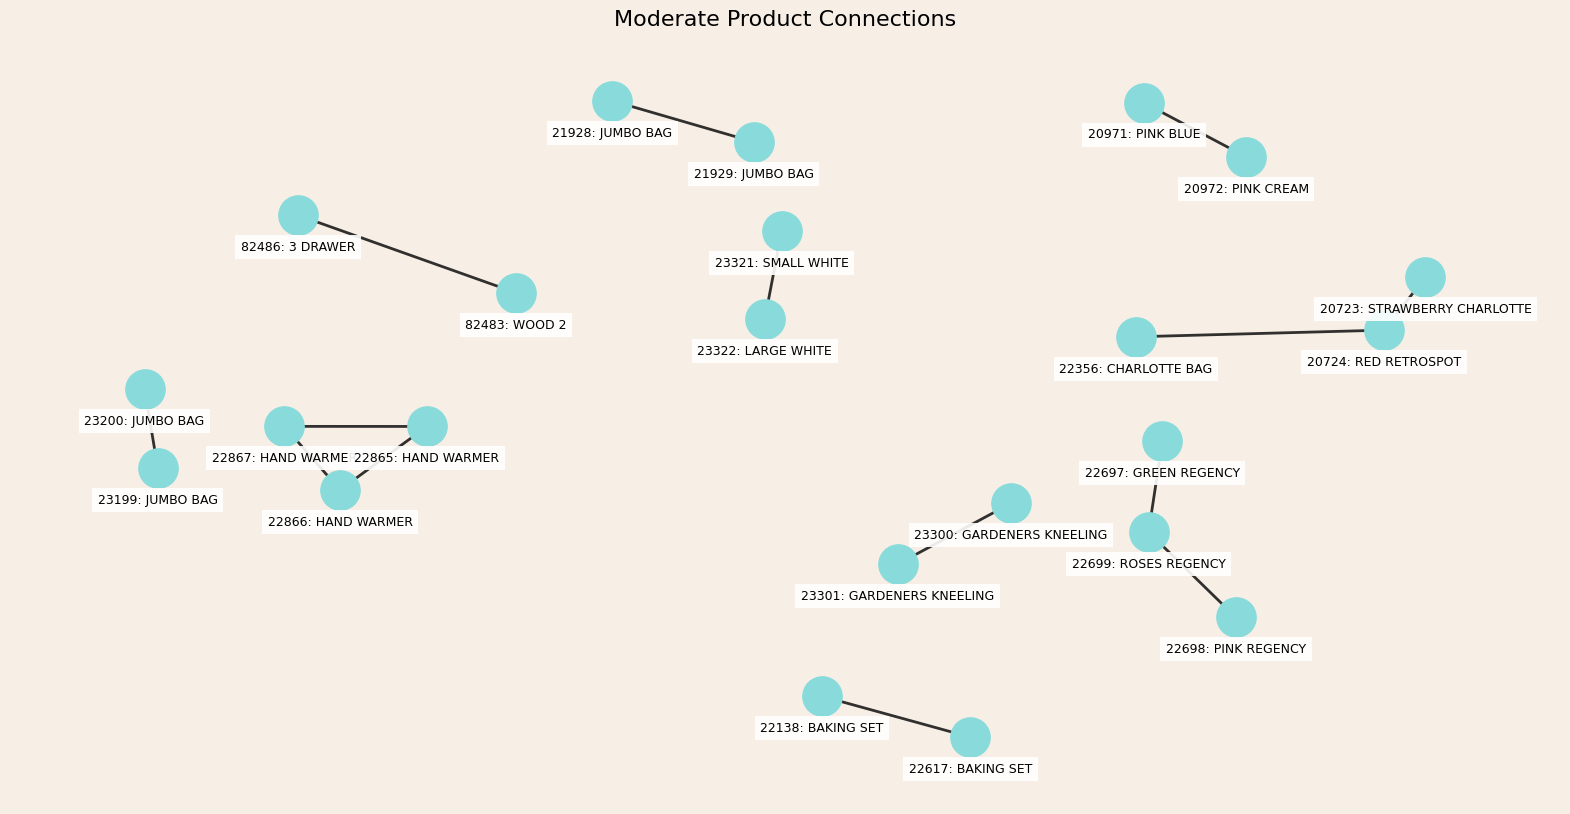

In [94]:
# Build the network graph to visualize connections between the products

plt.figure(figsize=(20, 10), facecolor="#f7efe6")
G_2 = nx.from_pandas_edgelist(graph_df_m, 'source', 'target', edge_attr='weight', create_using=nx.Graph())

# Set nodes positions and create nodes
pos = nx.spring_layout(G_2, k=0.5, seed=19, iterations=11)
nx.draw_networkx_nodes(G_2, pos, node_color='#89dbdb', node_size=800)

# Create and lable edges
edges = G_2.edges()
nx.draw_networkx_edges(G_2, pos, width=2, alpha=0.8)
pos_lab = {node: (x, y - 0.09) for node, (x, y) in pos.items()}
nx.draw_networkx_labels(G_2, pos_lab, font_size=9, bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))

plt.title("Moderate Product Connections", fontsize=16)
plt.axis('off')
plt.show()

In [60]:
# Create a table with full node descriptions
table_2 = rules_filt[rules_filt['lift'] < 19.0][['rank','ant_descr_c', 'ante_descr', 
                                     'cons_descr_c', 'conseq_descr']].rename(
    columns={'ant_descr_c': 'Node label on graph (A)', 
             'cons_descr_c': 'Node label on graph (C)', 
             'ante_descr':'Full product description (A)',
             'conseq_descr':'Full product description (C)'}).set_index('rank')

table_2.index.name = None
table_2

,Node label on graph (A),Full product description (A),Node label on graph (C),Full product description (C)
13,22867: HAND WARMER,HAND WARMER BIRD DESIGN,22866: HAND WARMER,HAND WARMER SCOTTY DOG DESIGN
14,22699: ROSES REGENCY,ROSES REGENCY TEACUP AND SAUCER,22697: GREEN REGENCY,GREEN REGENCY TEACUP AND SAUCER
15,20724: RED RETROSPOT,RED RETROSPOT CHARLOTTE BAG,22356: CHARLOTTE BAG,CHARLOTTE BAG PINK POLKADOT
16,22698: PINK REGENCY,PINK REGENCY TEACUP AND SAUCER,22699: ROSES REGENCY,ROSES REGENCY TEACUP AND SAUCER
17,23199: JUMBO BAG,JUMBO BAG APPLES,23200: JUMBO BAG,JUMBO BAG PEARS
18,22865: HAND WARMER,HAND WARMER OWL DESIGN,22866: HAND WARMER,HAND WARMER SCOTTY DOG DESIGN
19,20972: PINK CREAM,PINK CREAM FELT CRAFT TRINKET BOX,20971: PINK BLUE,PINK BLUE FELT CRAFT TRINKET BOX
20,22867: HAND WARMER,HAND WARMER BIRD DESIGN,22865: HAND WARMER,HAND WARMER OWL DESIGN
21,20723: STRAWBERRY CHARLOTTE,STRAWBERRY CHARLOTTE BAG,20724: RED RETROSPOT,RED RETROSPOT CHARLOTTE BAG
22,21929: JUMBO BAG,JUMBO BAG PINK VINTAGE PAISLEY,21928: JUMBO BAG,JUMBO BAG SCANDINAVIAN BLUE PAISLEY


**Table 2. Moderate Product Connections. Node Descriptions**

**Key Findings:**
- **Top 3 assosiations among the moderate connections** have 3 products. The rest 7 out of the 10 connections contain 2 products. These groups are also **logically similar**. They vary by:
    - **Color / Design**: Hand Warmer Scotty Dog Design & Hand Warmer Bird Design,  Charlotte Bag Pink Polkadot & Red Retrospot Charlotte Bag,
    - **Type**: Wood 2 Drawer Cabinet White Finish & 3 Drawer Antique White Wood Cabinet.
- The moderate part of connections has no clusters **longer that 3 products**, but one of the strongest assosiations found here was a part of the largest tea-related group (REGENCY) from the previuos graph.
- **13 out of the 14 products** in this subset vary specifically **by design**.

**Business insights:**
1. **Bundle-selling Opportunities**
    - Bundle examples:  Hand Warmer Scotty Dog Design & Bird Design, Charlotte Bag Pink Polkadot & Red Retrospot.
2. **Personalized Product Recommendations**
    - Examples with moderate assosiations: Viewing PINK CREAM FELT CRAFT TRINKET BOX - recommend PINK BLUE FELT CRAFT TRINKET BOX.

### 5.2 Product Networks & Communities (Louvain)

To better understand relationships between products, association rules will be expanded into all pairwise combinations of antecedents and consequents. This will generate a network of co-purchased products, which can be analyzed to identify connected sets of items. Visualizing these groups helps reveal patterns in customer purchasing behavior and the connections between popular products.

In [77]:
# # Install python-louvain package
# %pip install python-louvain

In [61]:
import itertools
from community import community_louvain

# Expand association rules into pairwise product candidates
pair_candidates = []

for _, row in rules_full.iterrows():
    antecedents = row['antecedents']
    consequents = row['consequents'] 
    for a, b in itertools.product(antecedents, consequents):    # combine all into antecedents and consequents pairs
        pair_candidates.append((a, b))

        
# Create DataFrame of unique product pairs
pair_df = pd.DataFrame(pair_candidates, columns=['product_A', 'product_B'])
pair_df = pair_df.drop_duplicates().reset_index(drop=True)

pair_df.head()

,product_A,product_B
0,22916,22917
1,22916,22918
2,22917,22918
3,22920,22918
4,22920,22917


In [62]:
# Calculate basic metrics for the Network analysis

# Number of baskets
n_baskets = gift_order_df.shape[0]

# Support for individual products
item_support = gift_order_df.mean()

# Calculate pairwise support
pair_metrics = []

for _, row in pair_df.iterrows():
    a = row['product_A']
    b = row['product_B']
    
    # Joint occurrence of A and B in baskets
    joint_support = (gift_order_df[a] & gift_order_df[b]).mean()
    
    pair_metrics.append({
        'product_A': a,
        'product_B': b,
        'support_AB': joint_support
    })

pair_metrics_df = pd.DataFrame(pair_metrics)


# Add individual supports
pair_metrics_df['support_A'] = pair_metrics_df['product_A'].map(item_support)
pair_metrics_df['support_B'] = pair_metrics_df['product_B'].map(item_support)

# Calculate pairwise lift and leverage
pair_metrics_df['lift'] = (pair_metrics_df['support_AB'] /
    (pair_metrics_df['support_A'] * pair_metrics_df['support_B']))

pair_metrics_df['leverage'] = (pair_metrics_df['support_AB'] -
    pair_metrics_df['support_A'] * pair_metrics_df['support_B'])

# Filter weak connections
pair_metrics_df = pair_metrics_df[(pair_metrics_df['lift'] > 1.0) &
    (pair_metrics_df['leverage'] > 0)].reset_index(drop=True)


pair_metrics_df

,product_A,product_B,support_AB,support_A,support_B,lift,leverage
0,22916,22917,0.010591,0.011221,0.011347,83.176779,0.010463
1,22916,22918,0.010339,0.011221,0.011158,82.572589,0.010213
2,22917,22918,0.010402,0.011347,0.011158,82.153013,0.010275
3,22920,22918,0.010149,0.011158,0.011158,81.520093,0.010025
4,22920,22917,0.010275,0.011158,0.011347,81.157219,0.010149
...,...,...,...,...,...,...,...
349,21034,85123A,0.010339,0.053584,0.113282,1.703186,0.004268
350,85123A,22720,0.011662,0.113282,0.063103,1.631454,0.004514
351,20727,85123A,0.011032,0.061401,0.113282,1.586048,0.004076
352,85099B,85123A,0.013869,0.079115,0.113282,1.547448,0.004906


**Association rules** were used in the first stage exclusively **to select** potentially significant product relationships. Since one node (antecedent or consequent) in the assosiation rules can contain more than 1 element and network analysis works on pairwise (one-to-one) relationships between nodes, all assiciations were transformed into pairs of products.  
  
At the second stage, the strength of these pairwise relationships was **re-evaluated** at the shopping basket level by calculating support, lift, and leverage for each pair of products. After transformating multi-item associations into pairs, the values could not stay the same, because they reflect other purchasing patters, than individual pair effects.

This approach preserves MBA's sensitivity to complex purchasing patterns and helps to achieve the correct interpretation of pairwise relationships in the network model.

In [83]:
# Build graph
G_na = nx.Graph()
for _, row in pair_metrics_df.iterrows():
    G_na.add_edge(row['product_A'], row['product_B'], weight=row['lift'])

# Сalculate degree and strength
degree_dict = dict(G_na.degree())
strength_dict = dict(G_na.degree(weight='weight'))

# Run Louvain
partition = community_louvain.best_partition(G_na, weight='weight', random_state=25)

# Save results
node_metrics = pd.DataFrame({
    'product': list(G_na.nodes()),
    'degree': [degree_dict[n] for n in G_na.nodes()],
    'strength': [strength_dict[n] for n in G_na.nodes()],
    'community': [partition[n] for n in G_na.nodes()]
})

# Add descriptions
node_metrics['description'] = node_metrics['product'].map(descr)

node_metrics

,product,degree,strength,community,description
0,22916,4,325.274051,0,HERB MARKER THYME
1,22917,4,325.993593,0,HERB MARKER ROSEMARY
2,22918,4,326.125701,0,HERB MARKER PARSLEY
3,22920,4,322.645286,0,HERB MARKER BASIL
4,22919,4,316.755013,0,HERB MARKER MINT
...,...,...,...,...,...
176,22189,1,3.395189,32,CREAM HEART CARD HOLDER
177,84836,1,3.268716,32,ZINC METAL HEART DECORATION
178,22457,1,2.454703,32,NATURAL SLATE HEART CHALKBOARD
179,20914,1,2.118090,32,SET/5 RED RETROSPOT LID GLASS BOWLS


In [86]:
# Get the items frequently bought together with other items
node_metrics.sort_values('degree', ascending=False).head(15)[['product', 'description', 
                                                              'degree', 'community']].reset_index(drop=True)

,product,description,degree,community
0,85123A,CREAM HANGING HEART T-LIGHT HOLDER,27,32
1,85099B,JUMBO BAG RED RETROSPOT,25,16
2,20725,LUNCH BAG RED RETROSPOT,22,16
3,22383,LUNCH BAG SUKI DESIGN,19,16
4,20727,LUNCH BAG BLACK SKULL.,18,16
5,22386,JUMBO BAG PINK POLKADOT,18,16
6,21931,JUMBO STORAGE BAG SUKI,17,16
7,23203,JUMBO BAG VINTAGE DOILY,17,16
8,23209,LUNCH BAG VINTAGE DOILEY,16,16
9,22384,LUNCH BAG PINK POLKADOT,16,16


**Table 3. Top 15 Products by Degree**

**Key Findings:**
- **14 out of 15** top by degree products belong to the **same community (Community 16)**, which shows that this group of products is very tightly connected.
- Most products in the group are **bags** (regular, fashion, lunch or storage bags). They appear in many different baskets and act as **popular, versatile items** rather than niche products.
- The only product outside this community is the **Hanging Heart Candle Holder**, which has the highest degree and connects with products from multiple groups.

**Business insights:**
- Bags can be used as key products for cross-selling, as customers often combine them with other items.
- The candle holder works well as an add-on or gift item, since it is often purchased together with products from different categories.
- Promotions and recommendations can benefit from treating bags as core products.

In [87]:
# Create a table with top products by strength
node_metrics.sort_values('strength', ascending=False).head(15)[['product', 'description', 
                                                                'strength', 'community']].reset_index(drop=True)

,product,description,strength,community
0,22918,HERB MARKER PARSLEY,326.125701,0
1,22917,HERB MARKER ROSEMARY,325.993593,0
2,22916,HERB MARKER THYME,325.274051,0
3,22920,HERB MARKER BASIL,322.645286,0
4,22919,HERB MARKER MINT,316.755013,0
5,85099B,JUMBO BAG RED RETROSPOT,129.611435,16
6,22386,JUMBO BAG PINK POLKADOT,123.525765,16
7,21931,JUMBO STORAGE BAG SUKI,122.925389,16
8,20725,LUNCH BAG RED RETROSPOT,119.666179,16
9,23172,REGENCY TEA PLATE PINK,117.367719,1


**Table 4. Top 15 Products by Strenght**

**Key Findings:**
- The top of the strength ranking is entirely dominated by **Community 0 - herb markers**, which is represented in full by all 5 of its products. Very high strength values show that they are **almost always bought together**.
- This suggests that Community 0 forms a **compact and self-contained product group**, with extremely strong internal connections and limited reliance on products outside the cluster.
- Other communities (lunch bags in Community 16 and tea plates in Community 1) appear lower in the ranking and show strong but less pronounced co-purchase patterns.

**Business insights:**
- **Herb markers should be offered as a complete set**, rather than promoted individually, since customers tend to buy all variants together.
- This community is well suited for **pre-packaged bundles or gift sets**, which could simplify the buying process and increase average order value.
- In contrast, bag-related products are better positioned for cross-selling.

***

#### 5.2.1 Top Product Communities Visualization

The network visualization will show top product communities computed using the Louvain algorithm with a fixed random seed to ensure reproducibility.

Node positions were manually optimized using spring_layout parameters (k and iterations) for clarity and saved in separate files for reproducible plotting.

In [88]:
import matplotlib.cm as cm

# Create labels for a network graph. The graph will represent 3 product communities that have the highest 'strength'.
# Choose not more than 5 of the most popular ('degree') products among the community.

# Shorten product descriptions: first two words become initials, third word stays full
def short_descr(text):
    words = text.split()   
    if len(words) >= 3:
        initials = ''.join(w[0] for w in words[:2])  # e.g. 'JUMBO BAG' → 'JB'
        return f"{initials} {words[2]}"              # 'RED'
    elif len(words) == 2:
        initials = ''.join(w[0] for w in words)
        return initials
    else:
        return words[0]

# Create a dict of product code - short description label
short_descr_dict = {product_code: f"{product_code}: {short_descr(v)}" 
                    for product_code, v in descr.items()}

# Find the top 3 communities by total strength
# The sum of edge weights (co-purchase relationships) in each community
community_strength = node_metrics.groupby('community')['strength'].sum().sort_values(ascending=False)
top_communities = community_strength.head(3).index.tolist()

# Select top 5 products per top community by degree (popularity)
top_nodes = []
for c in top_communities:
    commun_nodes = node_metrics[node_metrics['community'] == c]
    top_products = commun_nodes.sort_values(by='degree', ascending=False).head(5)['product'].tolist()
    top_nodes.extend(top_products)

In [157]:
# Load the positions for the subgraphs
import pickle

# with open("pos_top3_communities4.pkl", "rb") as f:
#     pos_c = pickle.load(f)
    
# Create subgraph including only the selected top products
G_sub = G_na.subgraph(top_nodes)

# Map product to community for nodes in subgraph
product_to_community = node_metrics.set_index('product')['community'].to_dict()

In [158]:
# Save layout input for interactive tuning
layout_data = {
    "G_sub": G_sub,
    "top_communities": top_communities,
    "product_to_community": product_to_community,
    "short_descr_dict": short_descr_dict
}

with open("layout_input.pkl", "wb") as f:
    pickle.dump(layout_data, f)

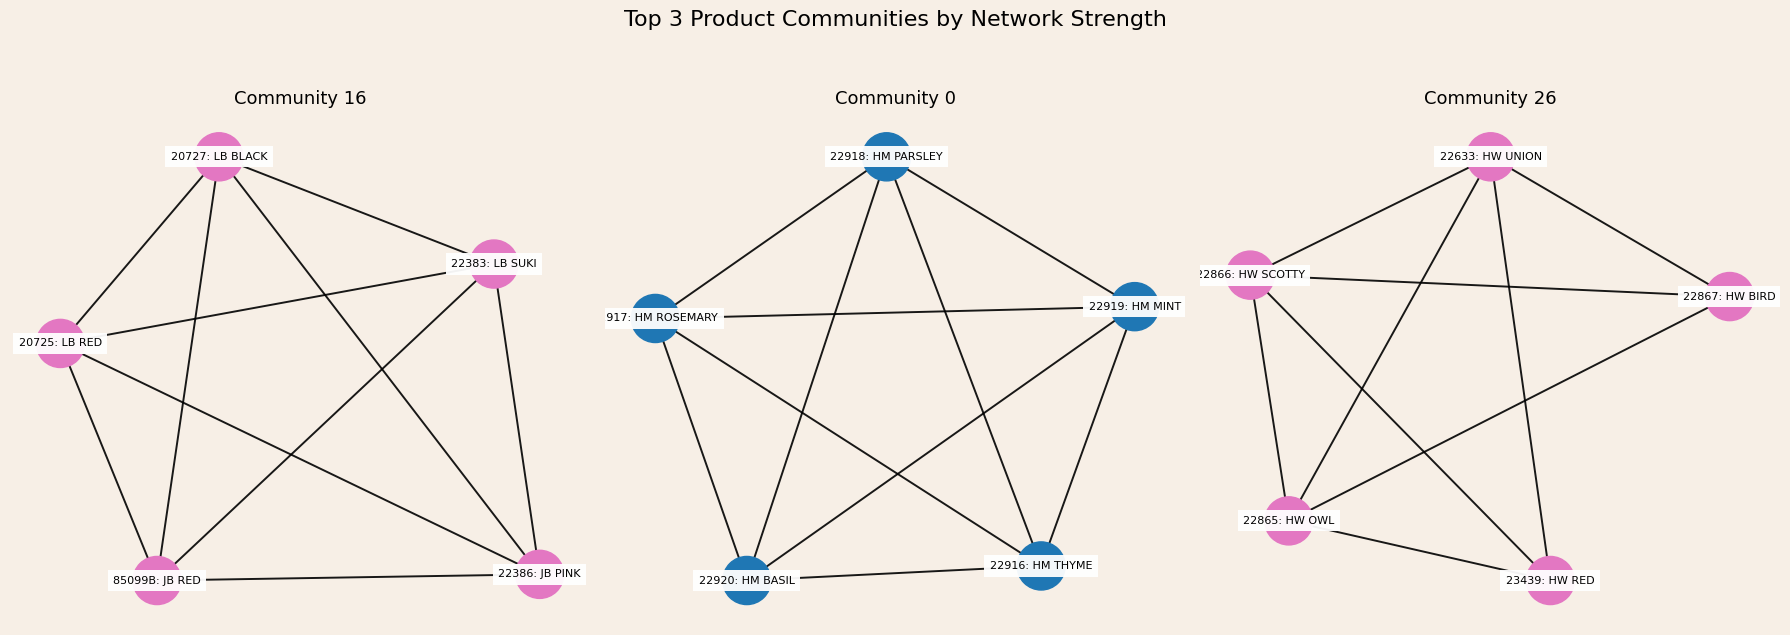

In [161]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx

# Load the precomputed positions
with open("pos_top3_communities_fixed.pkl", "rb") as f:
    pos_by_community = pickle.load(f)

# Set up node colors based on community
node_colors = {node: cm.tab10(product_to_community[node] % 10) for node in G_sub.nodes()}

# Plot settings
fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor="#f7efe6")
if len(top_communities) == 1:
    axes = [axes]  

for ax, c in zip(axes, top_communities):
    # Nodes in the current community
    nodes_c = [node for node in G_sub.nodes() if product_to_community[node] == c]

    # Subgraph for this community
    G_c = G_sub.subgraph(nodes_c)
    
    # Use loaded positions
    community_pos = {n: pos_by_community[c][n] for n in G_c.nodes()}

    # Draw nodes
    nx.draw_networkx_nodes(
        G_c, community_pos, ax=ax, 
        node_color=[node_colors[node] for node in G_c.nodes()], 
        node_size=1200, alpha=1
    )

    # Draw edges
    nx.draw_networkx_edges(
        G_c, community_pos, ax=ax, width=1.4, alpha=0.9, edge_color='black'
    )

    # Add labels
    community_labels = {
        node: short_descr_dict.get(node, descr.get(node, str(node))) 
        for node in G_c.nodes()
    }
    nx.draw_networkx_labels(
        G_c, community_pos, ax=ax,
        labels=community_labels, font_size=8,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.95)
    )
    
    ax.set_title(f"Community {c}", fontsize=13)
    ax.axis('off')

fig.suptitle("Top 3 Product Communities by Network Strength", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [167]:
# Display a table with full node descriptions

# Create a list to store dataframes for each of the top 3 communities
communities_dfs = []

for c in top_communities:
    df = node_metrics[node_metrics['community'] == c].copy()
    df = df.sort_values(by='degree', ascending=False).head(5)  # top-5 products based on 'degree'
    
    # Create short labels like on the graph
    df['short_label'] = df['product'].map(short_descr_dict)   # code + short description
    df['full_description'] = df['product'].map(descr)         # full description
    
    df = df.reset_index(drop=True)    # align rows across communities
    df = df[['short_label', 'full_description']]
    
    # Rename columns to reflect the community
    df.columns = [f'Community {c} - Product', f'Community {c} - Description']
    
    communities_dfs.append(df)

# Align lengths and concatenate horizontally
max_len = max(len(df) for df in communities_dfs)
final_table = pd.concat([df.reindex(range(max_len)) for df in communities_dfs], axis=1)
final_table = final_table.fillna('')  # replace NaN with empty string

final_table

,Community 16 - Product,Community 16 - Description,Community 0 - Product,Community 0 - Description,Community 26 - Product,Community 26 - Description
0,85099B: JB RED,JUMBO BAG RED RETROSPOT,22916: HM THYME,HERB MARKER THYME,22633: HW UNION,HAND WARMER UNION JACK
1,20725: LB RED,LUNCH BAG RED RETROSPOT,22917: HM ROSEMARY,HERB MARKER ROSEMARY,22866: HW SCOTTY,HAND WARMER SCOTTY DOG DESIGN
2,22383: LB SUKI,LUNCH BAG SUKI DESIGN,22918: HM PARSLEY,HERB MARKER PARSLEY,22865: HW OWL,HAND WARMER OWL DESIGN
3,20727: LB BLACK,LUNCH BAG BLACK SKULL.,22920: HM BASIL,HERB MARKER BASIL,23439: HW RED,HAND WARMER RED LOVE HEART
4,22386: JB PINK,JUMBO BAG PINK POLKADOT,22919: HM MINT,HERB MARKER MINT,22867: HW BIRD,HAND WARMER BIRD DESIGN


**Table 5. Product Descriptions for the Top 3 Communities**

**Key Insights:**  
 - The top three communities by strength are highly dense, with most products within each group being directly connected, indicating frequent co-purchases.
 - Products within each community largely belong to the same product type (e.g. herb markers, hand warmers, bags), with variation mostly in design, color, or labeling.
 - Popular products within groups form logically coherent communities, suggesting that the network structure reflects customer behavior rather than random links.

**Business Insights:**  
 - The three most frequently co-purchased product categories in the dataset are **herb markers, hand warmers and bags**. 
 - Category-specific bundles within these communities could increase basket size and support more effective cross-selling.
 - The most popular products within each group drive most co-purchases and are strong candidates for recommendations.

## 6. Key Insights

**Purchases and Returns**
- Returns represent only ~2% of transactions, but 37% of customers made at least one return, reflecting that returns are rare per order but more common across customers.
- Retail customers account for most purchases and most returns; wholesale customers return items less frequently.

**Retail vs Wholesale Behavior**
- Most orders are small (under 20 units), with a long tail of large orders indicating wholesale activity.
- Unit prices decrease as order quantity increases, reflecting volume discounts.
- Data-driven quantity thresholds allow a clear separation between retail (<=50 units) and wholesale (51+ units).

**Cohort Analysis**
- Overall customer retention is low, with a sharp drop after the first purchase.
- The December 2010 cohort shows unusually high and stable retention (32-50%), likely beacuse of seasonal or cohort-specific effects.

**Repeat Purchase Prediction (CatBoost)**
- The CatBoost model achieves moderate performance (AUC ≈ 0.78), indicating a reasonable ability to distinguish repeat buyers.
- The model is better at identifying customers likely to return than excluding non-returners.
- Behavioral and RFM features capture meaningful differences in customer behavior.

**Product Relationships & Communities**
- Strong product associations mostly involve small groups of similar items differing by design or color.
- Product communities detected by Louvain are logically connected and category-based (e.g., herb markers, hand warmers, bags).
- A small number of popular products drive most co-purchases within communities.

## 7. Business Recommendations

**Customer Retention**
- Focus on early-stage engagement (first month after purchase), where most churn occurs.
- Run campaigns around high-demand periods (like December 2010) to increase repeat purchases.

**Marketing & Personalization**
- Use the repeat-purchase model to prioritize customers likely to return, improving campaign efficiency.
- Target repeat buyers efficiently: Use the CatBoost model to target likely returning customers, keeping in mind some may not actually return.

**Product & Merchandising Strategy**
- Offer pre-packaged bundles for tightly connected products (e.g., herb marker or hand warmer sets).
- Use popular bag products as cross-selling anchors, since they connect to many categories.
- Recommend visually or functionally similar products based on network connections.

## 8. Appendices
### 8.1 CatBoost Feature Correlations
The table below shows pairwise correlations between features used for CatBoost modeling.

In [172]:
# CatBoost Model Input Feature Correlations
corr_matrix_spearman.round(4)

,Monetary,UnitPriceMedian,UnitPriceStd,OrderValueMedian,OrderValueMax,OrderValueStd,QuantityAvg,UniqueItemsAvg,ExpensiveItems,CheapItems,DaysBetweenMedian,DaysBetweenMax,DayOfWeekMedian,MonthMedian,HourMedian,LastMonthOrders,PurchaseFrequency,ItemRepeat
Monetary,1.0000,-0.0021,0.6218,0.6198,0.8600,0.7581,0.5539,0.3825,0.0846,0.0540,-0.3424,-0.1267,-0.0366,-0.0287,-0.0669,0.3429,-0.5354,0.7214
UnitPriceMedian,-0.0021,1.0000,0.1298,0.0552,0.0444,-0.0028,-0.3744,-0.1840,0.2538,-0.2752,-0.0115,-0.0346,-0.0021,-0.0752,-0.0131,-0.0750,0.0503,-0.0730
UnitPriceStd,0.6218,0.1298,1.0000,0.0297,0.3505,0.8085,0.0147,-0.0489,0.2328,0.1541,-0.2955,-0.1276,-0.0091,-0.0806,-0.0229,0.2518,-0.6774,0.6477
OrderValueMedian,0.6198,0.0552,0.0297,1.0000,0.8517,0.2532,0.7997,0.5704,-0.0200,-0.1331,0.0177,0.0270,-0.0419,0.0679,-0.0669,0.0958,-0.0980,0.1267
OrderValueMax,0.8600,0.0444,0.3505,0.8517,1.0000,0.6038,0.7358,0.5047,0.0650,-0.0261,-0.1933,-0.0554,-0.0347,0.0337,-0.0622,0.2333,-0.2928,0.3944
OrderValueStd,0.7581,-0.0028,0.8085,0.2532,0.6038,1.0000,0.2608,0.1454,0.1140,0.1160,-0.2915,-0.1079,0.0001,-0.0527,-0.0319,0.2767,-0.6938,0.6972
QuantityAvg,0.5539,-0.3744,0.0147,0.7997,0.7358,0.2608,1.0000,0.6509,-0.1314,0.0524,0.0044,0.0335,-0.0387,0.0947,-0.0451,0.1364,-0.1241,0.1296
UniqueItemsAvg,0.3825,-0.1840,-0.0489,0.5704,0.5047,0.1454,0.6509,1.0000,-0.1507,-0.1223,0.0367,0.0542,0.0439,0.0744,0.1017,0.0882,-0.0899,0.0820
ExpensiveItems,0.0846,0.2538,0.2328,-0.0200,0.0650,0.1140,-0.1314,-0.1507,1.0000,-0.0036,-0.1201,-0.0628,0.0051,-0.0495,-0.0078,-0.0076,-0.0209,0.0421
CheapItems,0.0540,-0.2752,0.1541,-0.1331,-0.0261,0.1160,0.0524,-0.1223,-0.0036,1.0000,-0.1091,-0.0466,-0.0230,-0.0178,-0.0106,0.0747,-0.0685,0.1105


### 8.2 All Nodes for Top Product Communities
  
This table contains full descriptions of products within the top 3 communities identified by the Louvain algorithm. It can be used to verify network visualizations and for further analysis.

In [173]:
# Display all the products in the top communities
node_metrics[node_metrics['community'].isin(top_communities)].sort_values('community')[['community', 
                                                                                        'description']].reset_index(drop=True)

,community,description
0,0,HERB MARKER THYME
1,0,HERB MARKER ROSEMARY
2,0,HERB MARKER PARSLEY
3,0,HERB MARKER BASIL
4,0,HERB MARKER MINT
5,16,JUMBO BAG VINTAGE LEAF
6,16,JUMBO BAG PEARS
7,16,JUMBO BAG APPLES
8,16,JUMBO BAG VINTAGE DOILY
9,16,JUMBO BAG PINK VINTAGE PAISLEY
